# EK381 Exploratory Data Analysis <br> Lab 11: Machine Learning

### This lab was completed by Rawisara Chairat.

### Please clear all outputs before submitting this lab.

This lab overviews the exciting field of **machine learning**. All of the functions have been written for you, with an emphasis on visualization. Your goal should be to build a basic understanding and visual intuition for the following concepts:
- Binary Classification
- Training and Testing Data
- Training and Testing Error Rates
- Decision Regions for Basic Classifiers: Nearest Neighbor, Closest Average, LDA, QDA
- Overfitting
- Principal Component Analysis and Dimensionality Reduction
- Cross-Validation for Parameter Optimization (i.e., selecting the best dimension without looking at the test set)

You should set aside a bit more time than usual to fully understand these concepts, rather than just trying to run all of the cells quickly. We encourage you to reach out to course staff if you are confused with any particular concept.

If you find this material interesting, we encourage you to consider taking:
- EC 414: Introduction to Machine Learning (or EC 503 for a more mathematical perspective or BE 559 for a more biomedical perspective)
- EC 418: Reinforcement Learning

and perhaps one of the advanced courses:
- EC 518: Robot Learning
- EC 523: Deep Learning
- EC 525: Optimization for Machine Learning

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy.stats as st
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.datasets import make_moons, fetch_openml
from pathlib import Path
from skimage.io import imread
from skimage.color import rgb2gray

The code below loads four 2-dimensional datasets.

In [12]:
#2D Dataset 1
n1 = 20 #number of samples per hypothesis
mu1_0 = np.array([1,0]) 
mu1_1 = np.array([-1,0])
Sigma1_0 = np.array([[1.5,1.2],[1.2,1.5]]) 
Sigma1_1 = np.array([[1.5,1],[1,1.5]])
dataset1_0 = np.hstack((st.multivariate_normal.rvs(mu1_0,Sigma1_0,n1),np.zeros((n1,1))))
dataset1_1 = np.hstack((st.multivariate_normal.rvs(mu1_1,Sigma1_1,n1),np.ones((n1,1))))
dataset1 = np.vstack((dataset1_0,dataset1_1))
df1 = pd.DataFrame(columns=['X1','X2','Y'],data=dataset1) #Create a dataframe

#2D Dataset 2
n2 = 500 #number of samples per hypothesis
mu2_0 = np.array([1,1]) 
mu2_1 = np.array([0,0]) 
Sigma2_0 = np.array([[1,0.8],[0.8,1]]) 
Sigma2_1 = np.array([[1,-0.5],[-0.5,1]])
dataset2_0 = np.hstack((st.multivariate_normal.rvs(mu2_0,Sigma2_0,n2),np.zeros((n2,1))))
dataset2_1 = np.hstack((st.multivariate_normal.rvs(mu2_1,Sigma2_1,n2),np.ones((n2,1))))
dataset2 = np.vstack((dataset2_0,dataset2_1))
df2 = pd.DataFrame(columns=['X1','X2','Y'],data=dataset2) #Create a dataframe

#2D Dataset 3
n3 = 500 #number of samples total
moons_features,moons_labels = make_moons(n_samples=n3, noise=0.2)
df3 = pd.DataFrame(columns=['X1', 'X2', 'Y'], data=np.hstack((moons_features, moons_labels.reshape(-1, 1))))

#2D Dataset 4
n4 = 10 #number of samples per hypothesis
mu4_0 = np.array([2,1]) 
mu4_1 = np.array([-2,-1])
Sigma4_0 = np.array([[10,0],[0,10]]) 
Sigma4_1 = np.array([[10,0],[0,10]])
dataset4_0 = np.hstack((st.multivariate_normal.rvs(mu4_0,Sigma4_0,n4),np.zeros((n4,1))))
dataset4_1 = np.hstack((st.multivariate_normal.rvs(mu4_1,Sigma4_1,n4),np.ones((n4,1))))
dataset4 = np.vstack((dataset4_0,dataset4_1))
df4 = pd.DataFrame(columns=['X1','X2','Y'],data=dataset4) #Create a dataframe

In previous labs, we designated some part of the dataset as the **training** dataset, which could be used to learn the probability model, determine the classification rule, and learn any involved parameters. The remaining part of the dataset is the **testing** dataset, which is used to estimate the real-world performance of our classifier. The testing data may not be used in any way to determine our classifier, even for something as small as fine-tuning a parameter. As you will see, the training error is usually significantly lower than the testing error, since the classifier is either explicitly or implicitly using the true labels from the training data in setting its decision boundaries. 

It turns out we can do better: we can swap the training and testing datasets, allowing us to obtain two estimates of the error rates, which we can average for a better overall estimate. Taking this further, a better way to utilize our data is to break it into **folds**. For example, let's say we have 1000 data points, and we decide to split our dataset into 4 folds. Then, 1000/4 = 250 data points will be randomly selected (without replacement) for Fold A, 250 for Fold B, 250 for Fold C, and 250 for Fold D. We will then run the training process and estimating the error rates four times, using the following allocations

|Run #|Training Set|Testing Set|Training Error|Testing Error| 
|-----|------------|-----------|--------------|-------------|
|  1  | Folds A,B,C|   Fold D  | $\mathrm{Train~Error}~1$|$\mathrm{Test~Error}~1$|
|  2  | Folds A,B,D|   Fold C  | $\mathrm{Train~Error}~2$|$\mathrm{Test~Error}~2$|
|  3  | Folds A,C,D|   Fold B  | $\mathrm{Train~Error}~3$|$\mathrm{Test~Error}~3$|
|  4  | Folds B,C,D|   Fold A  | $\mathrm{Train~Error}~4$|$\mathrm{Test~Error}~4$|

We can then estimate the training error rate by
$$\mathrm{Average~Train~Error} = \frac{1}{4} \sum_{i=1}^4 \mathrm{Train~Error}~i$$
and the testing error rate by
$$\mathrm{Average~Test~Error} = \frac{1}{4} \sum_{i=1}^4 \mathrm{Test~Error}~i$$

Overall, every data point is used exactly once as a testing data point, and this allows us to improve the quality of our error rate estimate.

Recall the following basic classifiers:
- **Closest Average:** First, estimate the mean vectors for each possible label (such as + and -) from the training data. Then, determine the decision regions for the maximum likelihood (ML) rule between vector Gaussian distributions with these mean vectors and identity covariance matrices. This is equivalent to assigning each data point to the label corresponding to the closest mean vector, and the resulting decision boundary will be a line.
- **Linear Discriminant Analysis:** First, estimate the mean vectors and covariance matrices for each possible label (such as + and -) from the training data. Then, pool together the covariance matrices to estimate a single covariance matrix for the entire dataset. Determine the decision regions for the maximum likelihood (ML) rule between vector Gaussian distributions with these mean vectors and the pooled covariance matrix. The resulting decision boundary will be a line, whose slope is now adapted to the shape of the covariance matrix.
- **Quadratic Discriminant Analysis:** First, estimate the mean vectors and covariance matrices for each possible label (such as + and -) from the training data. Then, pool together the covariance matrices to estimate a single covariance matrix for the entire dataset. Determine the decision regions for the maximum likelihood (ML) rule between vector Gaussian distributions with these mean vectors and covariance matrices. The resulting decision boundary will be curved.
- **Nearest Neighbor:** To label a data point, search for the closest point in the training dataset and output its label.

The code below takes in a dataframe and runs these classifiers on two of the feature dimensions. It outputs a plot for the training data, the decision regions, and misclassified points as well as a plot for the testing data, the decision regions (derived from the training data), and the misclassified points. Finally, it reports the training and testing errors rates. To get better estimates of the error rates, it partitions the entire data set into `num_folds` **folds**. For each run, it designates one fold as the testing dataset and uses the remaining folds as the training dataset. The overall training and testing error rates are obtained by averaging the results from individual folds. (The plots are generated only from the first fold.)

In [13]:
def binary_classifiers_2d(data, feature1_col, feature2_col, label_col, test_size=0.5, num_folds=5):
    classifiers = {
        'Closest Average': NearestCentroid(),
        'LDA': LinearDiscriminantAnalysis(),
        'QDA': QuadraticDiscriminantAnalysis(),
        'Nearest Neighbor': KNeighborsClassifier(n_neighbors=1),
    }

    avg_train_errors = {}
    avg_test_errors = {}

    for clf_name, clf in classifiers.items():
        train_errors = []
        test_errors = []

        if clf_name == 'Nearest Neighbor':
            print("Plotting the precise nearest-neighbor boundaries is very time consuming so the boundaries below are approximate.")

        for i in range(num_folds):
            # Extract features and labels
            X = data[[feature1_col, feature2_col]].values
            y = data[label_col].values

            # Encode labels to integers
            le = LabelEncoder()
            y_encoded = le.fit_transform(y)

            # Split into training and test sets
            X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
                X, y_encoded, test_size=test_size, stratify=y_encoded)

            # Fit classifier
            clf.fit(X_train, y_train_encoded)

            # Training errors
            y_pred_train_encoded = clf.predict(X_train)
            n_errors_train = (y_pred_train_encoded != y_train_encoded).sum()
            train_errors.append(n_errors_train / len(y_train_encoded))

            # Test errors
            y_pred_test_encoded = clf.predict(X_test)
            n_errors_test = (y_pred_test_encoded != y_test_encoded).sum()
            test_errors.append(n_errors_test / len(y_test_encoded))

            # Generate plots for the first split
            if i == 0:
                cmap_light = ListedColormap(['orange', 'blue'])
                colors = ['blue', 'orange']

                if clf_name == 'Nearest Neighbor':
                    # Use DecisionBoundaryDisplay for Nearest Neighbor
                    plt.figure()
                    DecisionBoundaryDisplay.from_estimator(
                        clf, X_train, response_method="predict", alpha=0.4, cmap=cmap_light
                    )
                    for idx in np.unique(y_train_encoded):
                        label = le.inverse_transform([idx])[0]
                        plt.scatter(X_train[y_train_encoded == idx, 0], X_train[y_train_encoded == idx, 1],
                                    c=colors[idx], edgecolor='k', marker='o', label=f'Class {label}')

                    # Misclassified points
                    misclassified_train = (y_pred_train_encoded != y_train_encoded)
                    plt.scatter(X_train[misclassified_train, 0], X_train[misclassified_train, 1],
                                c='red', marker='*', s=100, label='Misclassified')

                    plt.title(f'Training Data and Decision Regions ({clf_name})')
                    plt.legend()
                    plt.xlabel(feature1_col)
                    plt.ylabel(feature2_col)
                    plt.show()

                    plt.figure()
                    DecisionBoundaryDisplay.from_estimator(
                        clf, X_test, response_method="predict", alpha=0.4, cmap=cmap_light
                    )
                    for idx in np.unique(y_test_encoded):
                        label = le.inverse_transform([idx])[0]
                        plt.scatter(X_test[y_test_encoded == idx, 0], X_test[y_test_encoded == idx, 1],
                                    c=colors[idx], edgecolor='k', marker='o', label=f'Class {label}')

                    # Misclassified points
                    misclassified_test = (y_pred_test_encoded != y_test_encoded)
                    plt.scatter(X_test[misclassified_test, 0], X_test[misclassified_test, 1],
                                c='red', marker='*', s=100, label='Misclassified')

                    plt.title(f'Test Data and Decision Regions ({clf_name})')
                    plt.legend()
                    plt.xlabel(feature1_col)
                    plt.ylabel(feature2_col)
                    plt.show()
                else:
                    # Original method for all other classifiers
                    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
                    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
                    h = 0.01
                    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                         np.arange(y_min, y_max, h))
                    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
                    Z = Z.reshape(xx.shape)

                    plt.figure()
                    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)
                    for idx in np.unique(y_train_encoded):
                        label = le.inverse_transform([idx])[0]
                        plt.scatter(X_train[y_train_encoded == idx, 0], X_train[y_train_encoded == idx, 1],
                                    c=colors[idx], edgecolor='k', marker='o', label=f'Class {label}')

                    misclassified_train = (y_pred_train_encoded != y_train_encoded)
                    plt.scatter(X_train[misclassified_train, 0], X_train[misclassified_train, 1],
                                c='red', marker='*', s=100, label='Misclassified')

                    plt.title(f'Training Data and Decision Regions ({clf_name})')
                    plt.legend()
                    plt.xlabel(feature1_col)
                    plt.ylabel(feature2_col)
                    plt.show()

                    plt.figure()
                    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)
                    for idx in np.unique(y_test_encoded):
                        label = le.inverse_transform([idx])[0]
                        plt.scatter(X_test[y_test_encoded == idx, 0], X_test[y_test_encoded == idx, 1],
                                    c=colors[idx], edgecolor='k', marker='o', label=f'Class {label}')

                    misclassified_test = (y_pred_test_encoded != y_test_encoded)
                    plt.scatter(X_test[misclassified_test, 0], X_test[misclassified_test, 1],
                                c='red', marker='*', s=100, label='Misclassified')

                    plt.title(f'Test Data and Decision Regions ({clf_name})')
                    plt.legend()
                    plt.xlabel(feature1_col)
                    plt.ylabel(feature2_col)
                    plt.show()

        # Calculate average errors
        avg_train_errors[clf_name] = np.mean(train_errors)
        avg_test_errors[clf_name] = np.mean(test_errors)

    # Print average error rates
    print("\nAverage Training and Test Error Rates:")
    for clf_name in classifiers.keys():
        print(f"{clf_name.upper()}:")
        print(f"  Average Training Error: {avg_train_errors[clf_name]:.4f}")
        print(f"  Average Test Error: {avg_test_errors[clf_name]:.4f}")


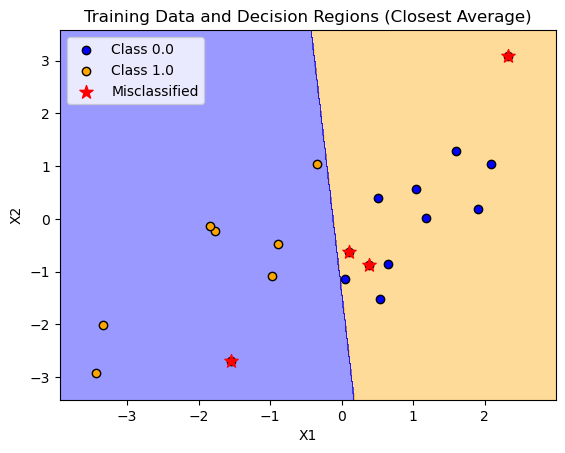

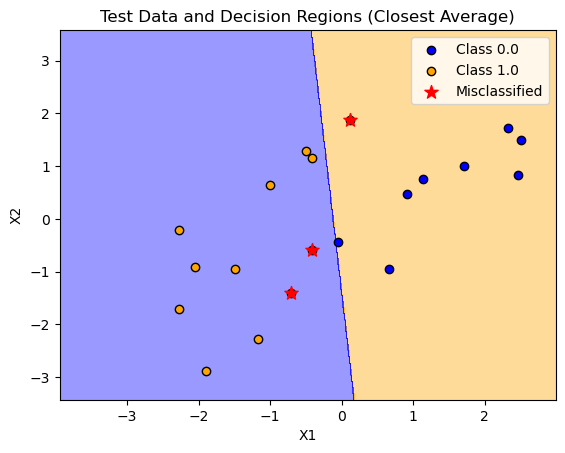

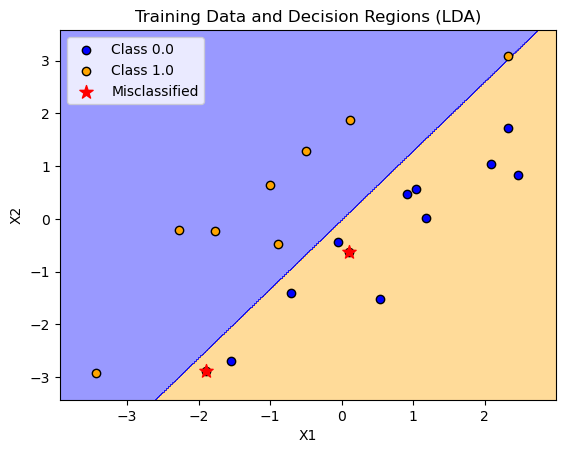

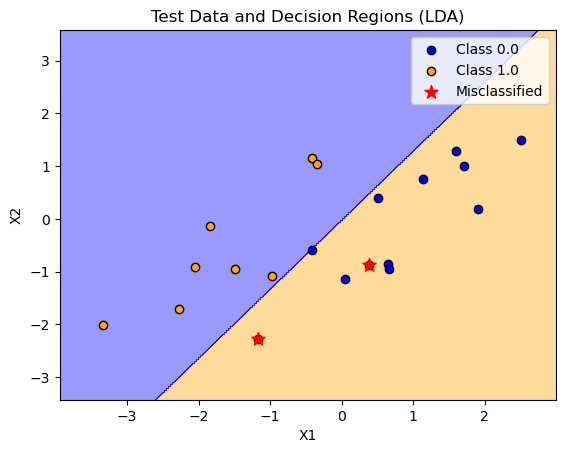

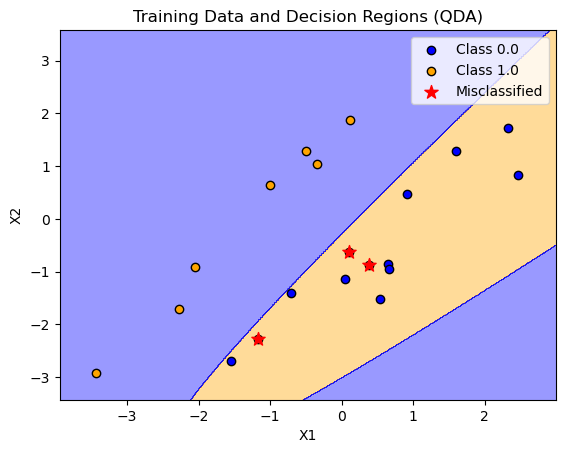

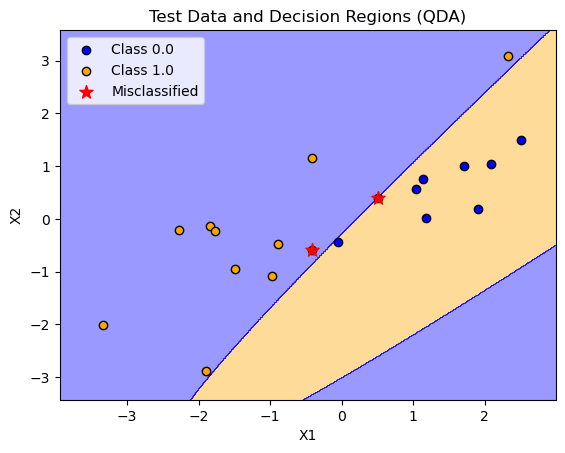

Plotting the precise nearest-neighbor boundaries is very time consuming so the boundaries below are approximate.


<Figure size 640x480 with 0 Axes>

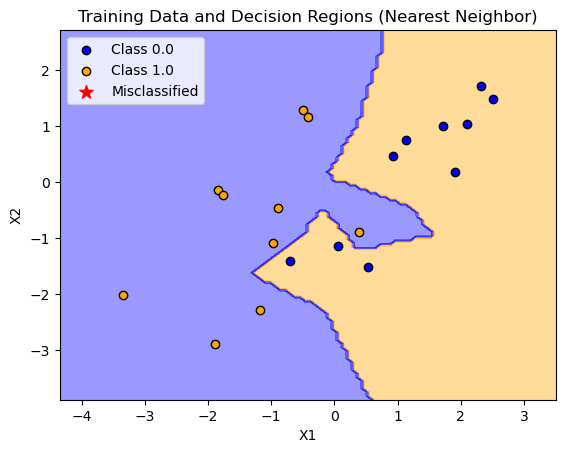

<Figure size 640x480 with 0 Axes>

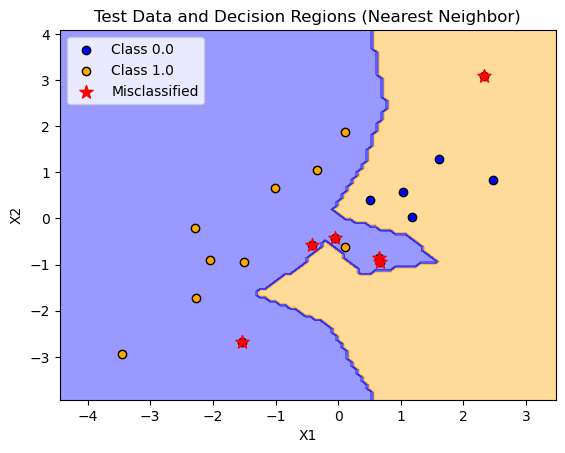


Average Training and Test Error Rates:
CLOSEST AVERAGE:
  Average Training Error: 0.2100
  Average Test Error: 0.2300
LDA:
  Average Training Error: 0.1100
  Average Test Error: 0.1600
QDA:
  Average Training Error: 0.1000
  Average Test Error: 0.1500
NEAREST NEIGHBOR:
  Average Training Error: 0.0000
  Average Test Error: 0.2600


In [14]:
binary_classifiers_2d(df1,'X1','X2','Y') #change df1 to df2,df3,df4 as needed

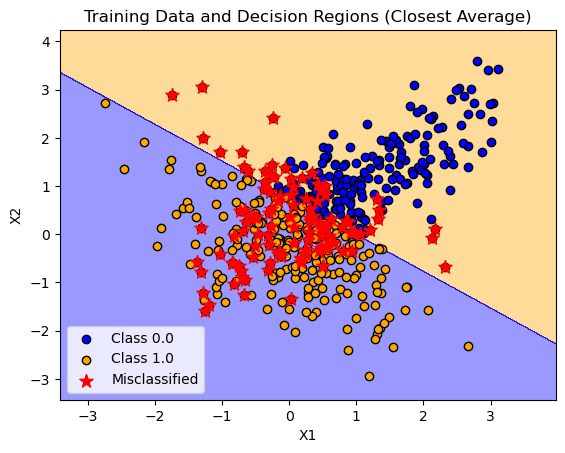

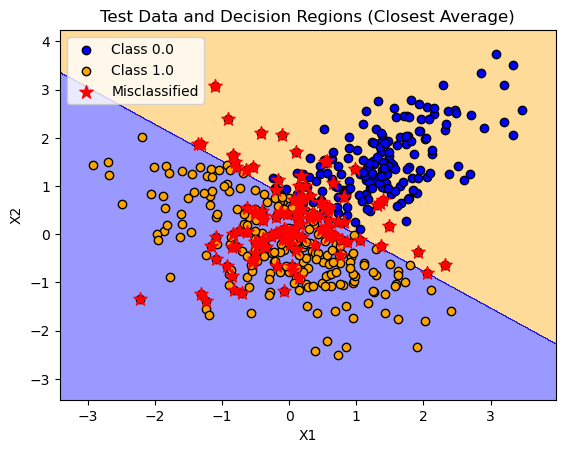

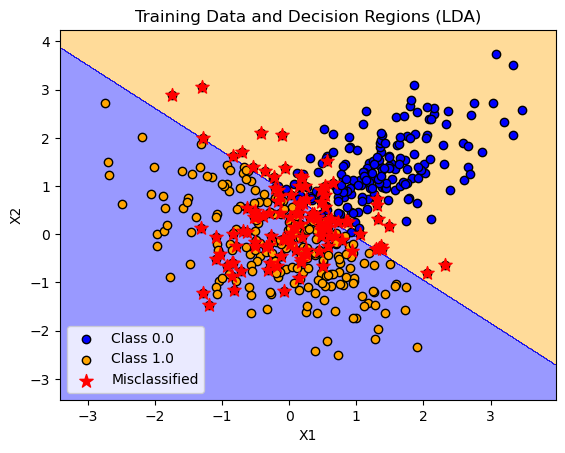

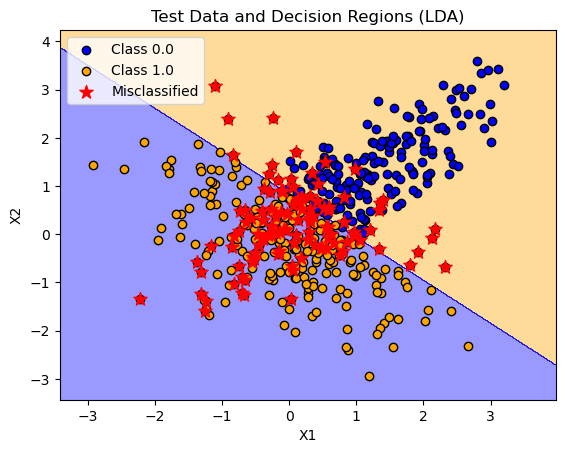

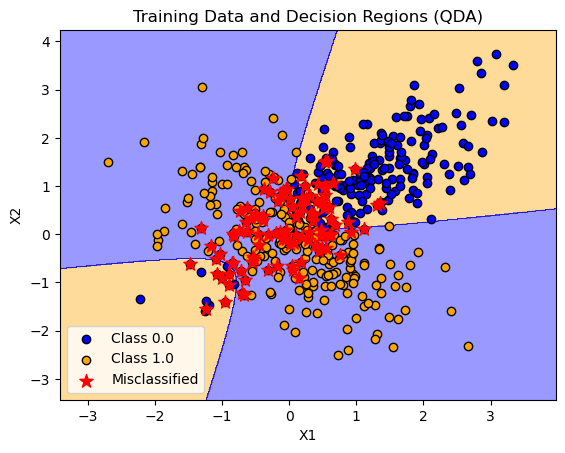

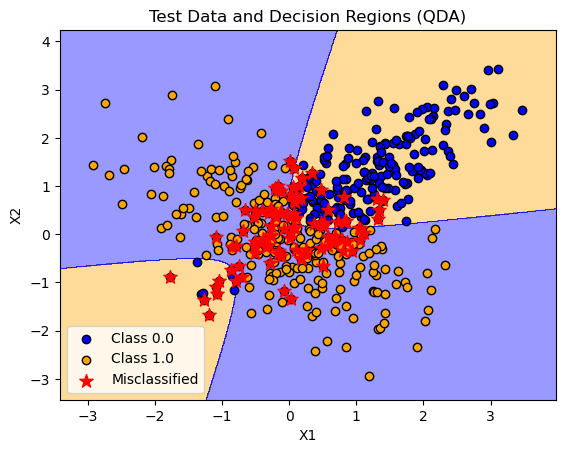

Plotting the precise nearest-neighbor boundaries is very time consuming so the boundaries below are approximate.


<Figure size 640x480 with 0 Axes>

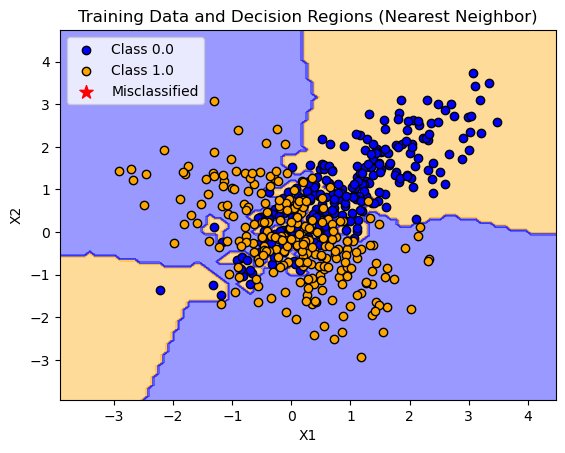

<Figure size 640x480 with 0 Axes>

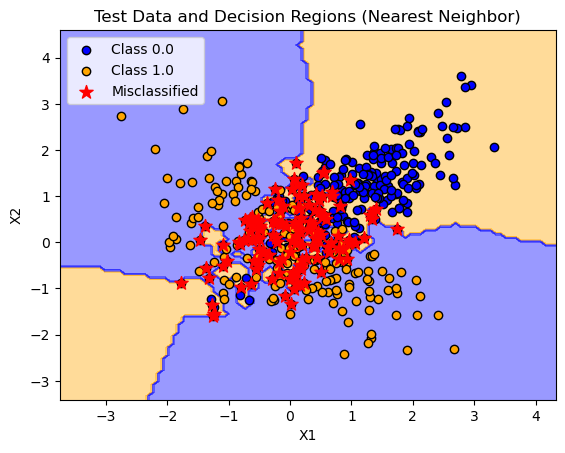


Average Training and Test Error Rates:
CLOSEST AVERAGE:
  Average Training Error: 0.2160
  Average Test Error: 0.2364
LDA:
  Average Training Error: 0.2276
  Average Test Error: 0.2236
QDA:
  Average Training Error: 0.2044
  Average Test Error: 0.2004
NEAREST NEIGHBOR:
  Average Training Error: 0.0000
  Average Test Error: 0.2740


In [15]:
binary_classifiers_2d(df2,'X1','X2','Y') #change df1 to df2,df3,df4 as needed

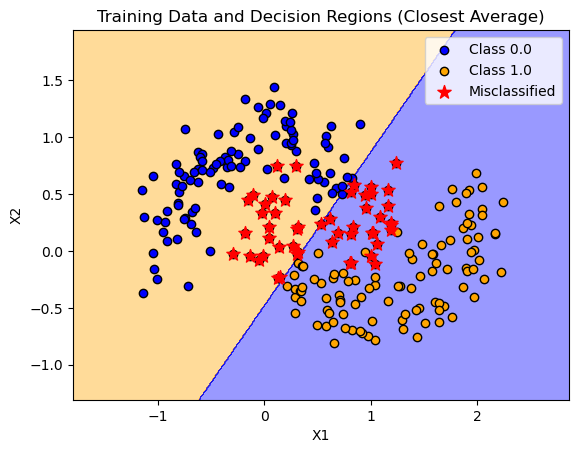

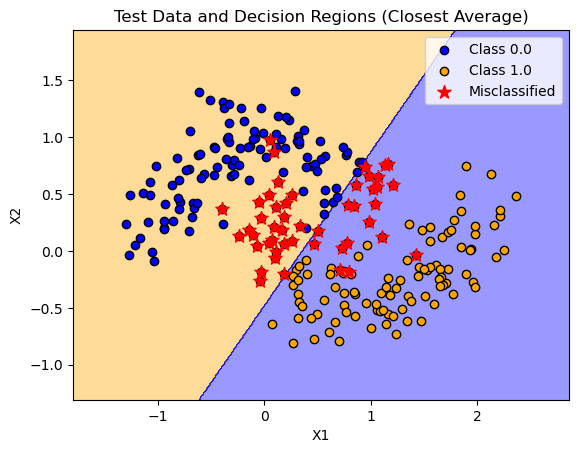

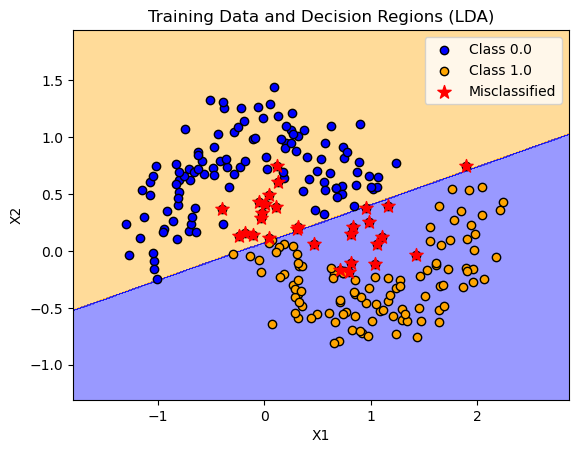

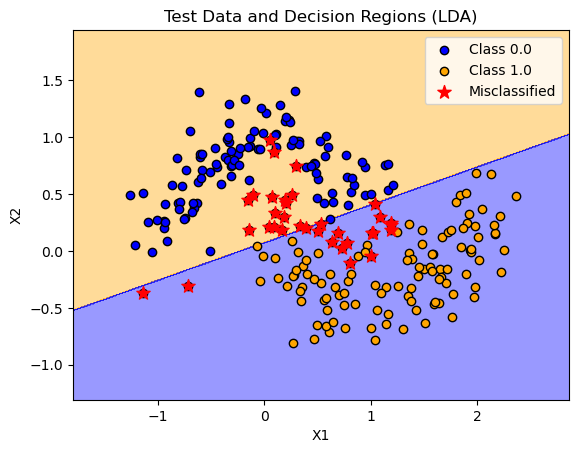

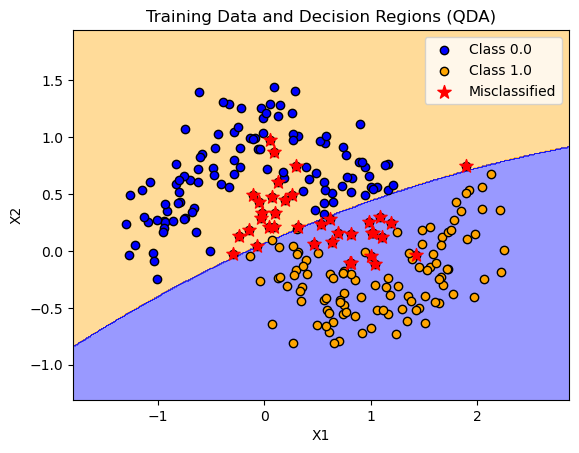

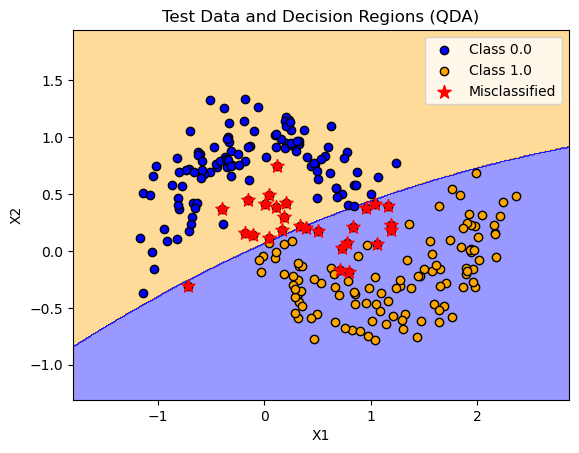

Plotting the precise nearest-neighbor boundaries is very time consuming so the boundaries below are approximate.


<Figure size 640x480 with 0 Axes>

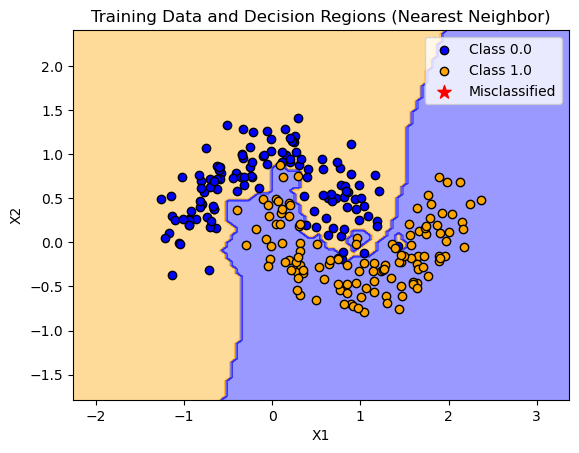

<Figure size 640x480 with 0 Axes>

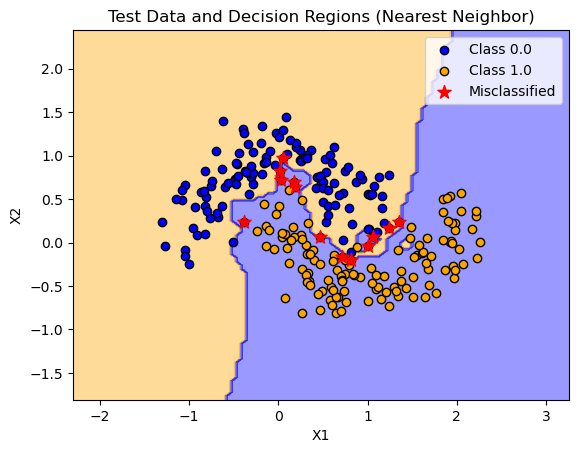


Average Training and Test Error Rates:
CLOSEST AVERAGE:
  Average Training Error: 0.1936
  Average Test Error: 0.1984
LDA:
  Average Training Error: 0.1144
  Average Test Error: 0.1424
QDA:
  Average Training Error: 0.1296
  Average Test Error: 0.1296
NEAREST NEIGHBOR:
  Average Training Error: 0.0000
  Average Test Error: 0.0488


In [16]:
binary_classifiers_2d(df3,'X1','X2','Y') #change df1 to df2,df3,df4 as needed

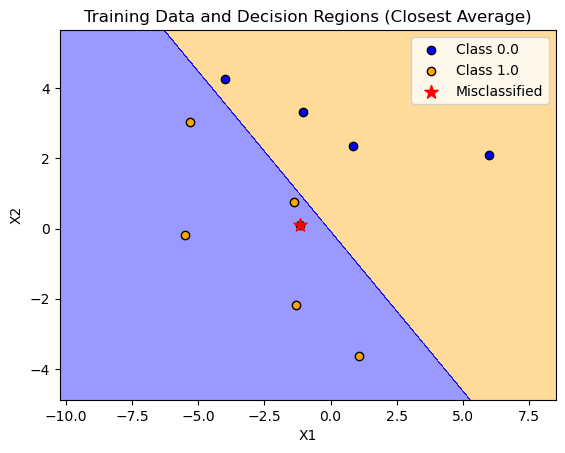

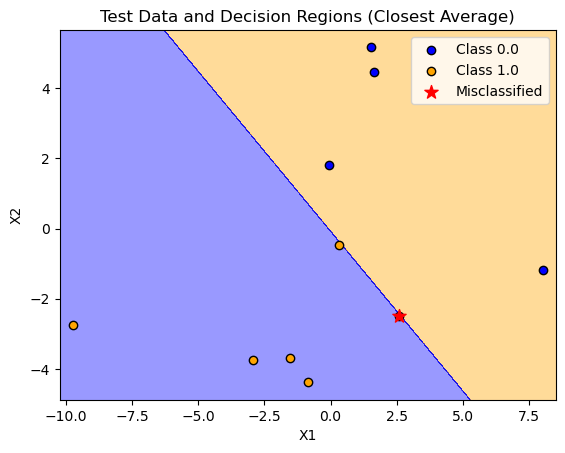

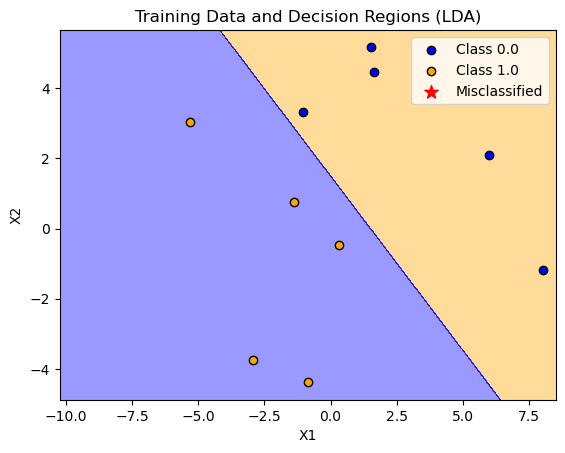

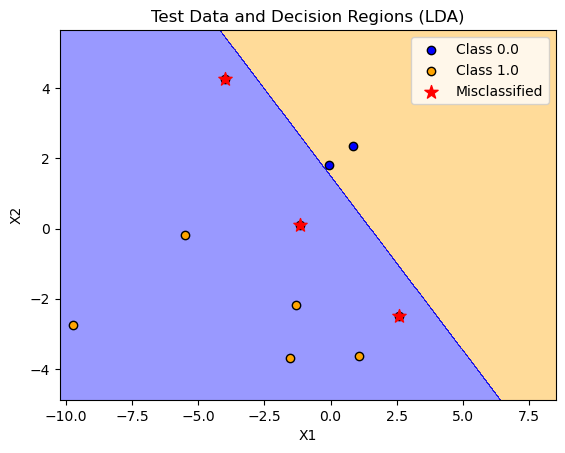

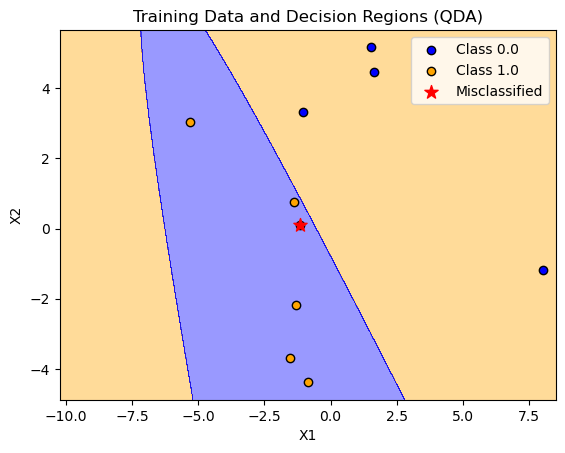

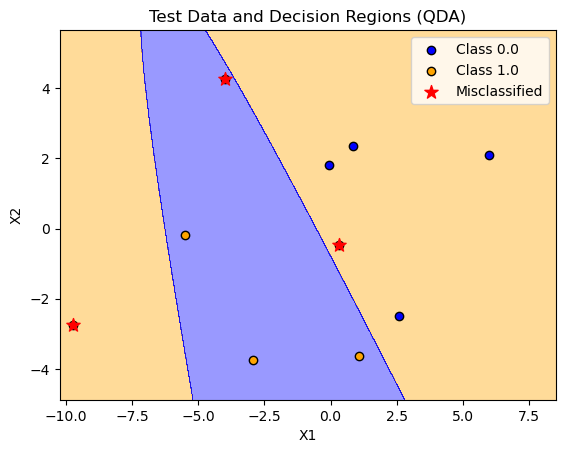

Plotting the precise nearest-neighbor boundaries is very time consuming so the boundaries below are approximate.


<Figure size 640x480 with 0 Axes>

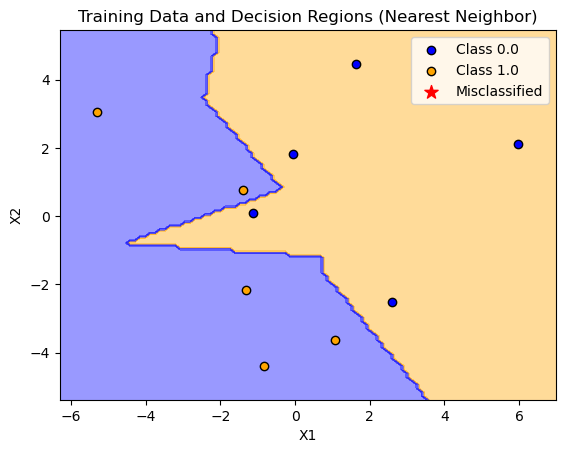

<Figure size 640x480 with 0 Axes>

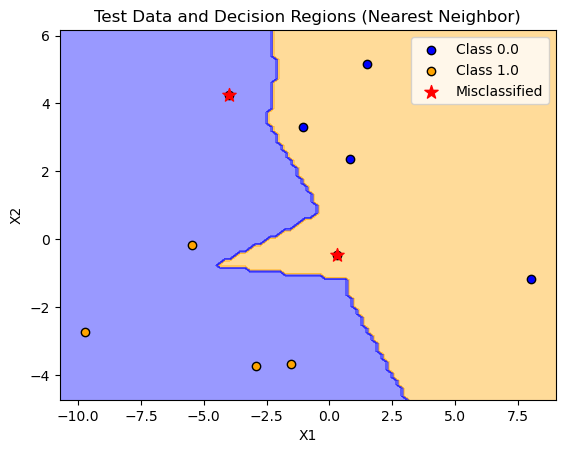


Average Training and Test Error Rates:
CLOSEST AVERAGE:
  Average Training Error: 0.1000
  Average Test Error: 0.1400
LDA:
  Average Training Error: 0.0600
  Average Test Error: 0.1800
QDA:
  Average Training Error: 0.1000
  Average Test Error: 0.2000
NEAREST NEIGHBOR:
  Average Training Error: 0.0000
  Average Test Error: 0.3000


In [17]:
binary_classifiers_2d(df4,'X1','X2','Y') #change df1 to df2,df3,df4 as needed

---
####  L11.1 Using the code above, run the basic classifiers on all four datasets `df1`, `df2`, `df3`, and `df4`. For each dataset, report which classifiers attained the lowest training error and test error. (The best classifier may vary from run to run due to the randomization in partitioning the data into folds. You can report the result from any run.) Afterwards, answer whether (a) Is there any classifier that is consistently the lowest in terms of training error across datasets? (b) Is there any classifier that is consistently the lowest in terms of testing error across datasets? 

#### df1, Classifier with Lowest Training Error: NEAREST NEIGHBOR
#### df1, Classifier with Lowest Test Error: QDA

#### df2, Classifier with Lowest Training Error: NEAREST NEIGHBOR
#### df2, Classifier with Lowest Test Error: QDA

#### df3, Classifier with Lowest Training Error: NEAREST NEIGHBOR
#### df3, Classifier with Lowest Test Error: LDA

#### df4, Classifier with Lowest Training Error: NEAREST NEIGHBOR
#### df4, Classifier with Lowest Test Error: NEAREST NEIGHBOR

#### Answer for (a): NEAREST NEIGHBOR

#### Answer for (b): QDA
---

Now, let's work some more complex data, where we do not have a good probability model to explain how the data is generated. This is where machine learning becomes more interesting. The key observation is that, even if we do not have enough data to build a good probability model, we can often build a good classifier!

Let's start with the **cats and dogs dataset**, which was created specifically for EK381. This dataset consists of 1000 cat images and 1000 dog images. Each image is grayscale and 64 x 64 = 4096 pixels. So far, we have worked with datasets where the number of examples $n$ exceeded the number of dimensions $d$. Here, we have more dimensions than examples, which will lead to some interesting classifier behavior. 

The first task is to read in the images and reshape them into vectors that are more suitable for our classifiers. The function below takes in folder paths and desired labels, and creates a data matrix where each image is represented by a row. The number of columns corresponds to the number of pixels (which is 4096 for the cats and dogs dataset).

In [18]:
def read_images(class_folders, labels):
    """
    Reads images from specified class folders and generates a data matrix (X) 
    and a label vector (y) for a binary classification problem.
    
    Parameters:
    - class_folders: List of paths to the class folders (e.g., ["catsfolder", "dogsfolder"]).
    - labels: List of corresponding labels for the classes (e.g., [-1, 1]).
    
    Returns:
    - X: Data matrix of shape (n_samples, n_features), where each row is an image.
    - img_shape: Tuple specifying the original image dimensions (e.g., (64, 64)).
    """
    data = []
    target = []
    img_shape = None  # To store the shape of the first image
    
    for folder, label in zip(class_folders, labels):
        folder_path = Path(folder)
        image_paths = list(folder_path.glob("*.jpg"))  # Match .jpg files
        
        for image_path in image_paths:
            img = imread(image_path)  # Read image as a NumPy array
            if img.ndim == 3:        # Convert RGB to grayscale if necessary
                img = rgb2gray(img)
            if img_shape is None:    # Save the shape of the first image
                img_shape = img.shape
            img_vector = img.flatten()  # Flatten the image into a 1D vector
            data.append(img_vector)
            target.append(label)
    
    X = np.array(data)  # Convert list of vectors to a 2D numpy array
    y = np.array(target)  # Convert list of labels to a 1D numpy array
    
    return X, y, img_shape

The code below reads in the cats and dogs image data. All you need to do is change the paths to match the file paths to your downloaded folders. (To get these folders, you need to first download the .zip file from the Lab 11 folder, then decompress it, usually by double clicking. Finally, move the catsfolder and dogsfolder to where you usually keep your datasets.)

In [19]:
# Change the paths below to your file paths to catsfolder and dogsfolder
class_folders = ["datasets/petdataset/catsfolder", "datasets/petdataset/dogsfolder"] 
labels = [-1, 1]

# Load the data
catdog_images, catdog_labels, catdog_img_shape = read_images(class_folders, labels)

print(f"Data shape: {catdog_images.shape}")  # (n_samples, n_features)
print(f"Labels shape: {catdog_labels.shape}")  # (n_samples,)
print(f"Image dimensions: {catdog_img_shape}") # img_shape

Data shape: (2000, 4096)
Labels shape: (2000,)
Image dimensions: (64, 64)


To get started, let's examine individual images in the dataset. The function below takes in a data matrix and an index `i`. It reshapes row `i` into an image of shape `img_shape` (which defaults to the cat and dog image size) and displays it. 

In [20]:
def show_image(X, i=None, img_shape=(64, 64)):
    """
    Displays an image as a grayscale plot. Works for both data matrices (n_samples, n_features) 
    and single image vectors (1D arrays).
    
    Parameters:
    - X: Either a data matrix of shape (n_samples, n_features) or a 1D image vector of length n_features.
    - i: Index of the row to be displayed (optional). If None, assumes X is a 1D array.
    - img_shape: Tuple specifying the image dimensions.
    
    Returns:
    - None
    """
    if i is not None:
        # Extract the ith row and reshape to the desired image dimensions
        image = X[i, :].reshape(img_shape)
    else:
        # Assume X is a 1D image vector
        image = X.reshape(img_shape)
    
    # Display the image
    plt.imshow(image, cmap='gray')
    plt.axis('off')  # Turn off axis for cleaner display
    plt.show()

Display a few images to get a sense for the dataset. The cats are numbered 0 to 999 and the dogs 1000 to 1999.

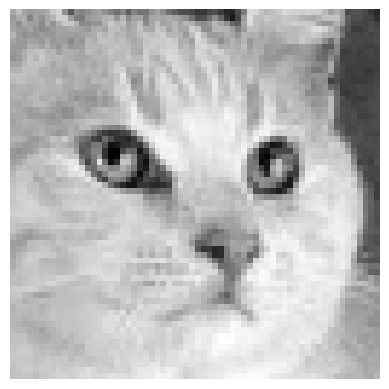

In [21]:
show_image(catdog_images,0)

Now, let's look at the average cat and average dog image. Below is code to calculate the sample mean vector across the cat data and then display it as an image. You should copy and modify it to display the average dog image.

Average Cat Image


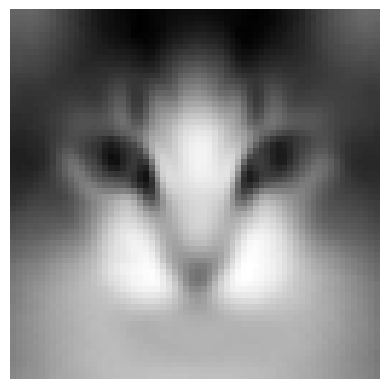

In [22]:
avgcat = np.mean(catdog_images[catdog_labels==-1],axis=0)
print('Average Cat Image')
show_image(avgcat)

Average Dog Image


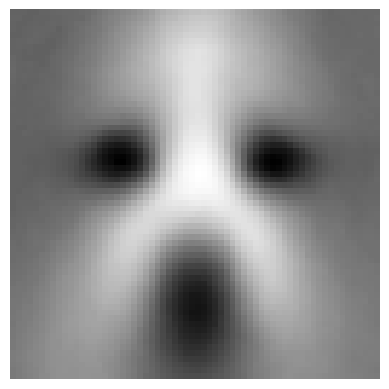

In [23]:
avgdog = np.mean(catdog_images[catdog_labels==+1],axis=0)
print('Average Dog Image')
show_image(avgdog)

---
####  L11.2 Using the code above, generate images of the average cat and average dog. Do these visually resemble a cat and dog? Based on this, do you think the closest average classifier will be able to attain a test error rate below 0.5?

#### Answer: The images resemble a cat and a dog. I think the closest average classifier will be able to attain a test error rate below 0.5 since there is a significant between the dog and cat according to these images.
---

The function below runs our four basic classifiers (nearest neighbor, closest average, LDA, and QDA) on image data. It takes as inputs a data matrix and a vector of labels as well as optional inputs corresponding to the image shape, number of folds, maximum number of displayed images, and whether to display images at all. Unlike the 2D setting above, we cannot visualize the classifiers directly in high-dimensional space. Instead, the code makes estimates of the training and test error rates by averaging across folds. It then displays images from the first fold's test data along with an orange, blue, green, and/or purple "X" if that image was misclassified by the classifer corresponding to that color. This allows us to maintain some visual representation of the classifier.

In [24]:
def image_classifier(X, y, img_shape=(64,64), num_folds=5, max_display_images=100, display_images=True):
    """
    Evaluates multiple classifiers using cross-validation and displays test images 
    with marks indicating model failures, along with a guide for the error marks.

    Parameters:
    - X: Data matrix of shape (n_samples, n_features).
    - y: Label vector of shape (n_samples,).
    - img_shape: Tuple specifying the image dimensions (default: (64, 64)).
    - num_folds: Number of training/test folds (default: 5).
    - max_display_images: Maximum number of test images to display (default: 100).
    
    Returns:
    - None
    """
    # Classifiers to evaluate
    classifiers = {
        "Nearest Neighbor": KNeighborsClassifier(n_neighbors=1),
        "Closest Average": NearestCentroid(),
        "LDA": LinearDiscriminantAnalysis(),
        "QDA": QuadraticDiscriminantAnalysis()
    }
    colors = ["orange", "blue", "green", "purple"]  # Colors for misclassification marks
    
    # Initialize Stratified K-Fold cross-validator
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True)
    
    # Initialize results tracking
    train_results = {name: [] for name in classifiers}
    test_results = {name: [] for name in classifiers}
    test_indices_list = []
    test_predictions = {name: [] for name in classifiers}

    # Cross-validation
    for fold_idx, (train_index, test_index) in enumerate(skf.split(X, y)):
        print(f"Processing fold {fold_idx + 1} of {num_folds}...")
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        test_indices_list.append(test_index)
        
        for name, clf in classifiers.items():
            clf.fit(X_train, y_train)
            y_train_pred = clf.predict(X_train)
            y_test_pred = clf.predict(X_test)
            train_results[name].append(1 - np.mean(y_train_pred == y_train))
            test_results[name].append(1 - np.mean(y_test_pred == y_test))  # Error rate
            test_predictions[name].append(y_test_pred)
    
    # Compute average error rates
    print("\nTraining Error Rates:")
    for name, errs in train_results.items():
        print(f"{name}: Average Training Error Rate: {np.mean(errs):.2f}")
    print("\nTesting Error Rates:")
    for name, errs in test_results.items():
        print(f"{name}: Average Testing Error Rate: {np.mean(errs):.2f}")

    if display_images: 
        # Visualize test set with misclassification marks
        # Use the first fold for visualization
        test_indices = test_indices_list[0]
        X_test = X[test_indices]
        y_test = y[test_indices]
        
        # Limit the number of test images to display
        num_images = min(len(X_test), max_display_images)
        half_num_images = num_images // 2
        front_indices = np.arange(half_num_images)
        end_indices = np.arange(len(X_test) - half_num_images, len(X_test))
        display_indices = np.concatenate([front_indices, end_indices])
        X_test = X_test[display_indices]
        y_test = y_test[display_indices]
        
        # Get predictions for the first fold
        fold_predictions = {name: preds[0][display_indices] for name, preds in test_predictions.items()}
    
        # Create the guide
        fig_guide, ax_guide = plt.subplots(figsize=(8, 2))  # Adjust height for the additional line
        ax_guide.axis('off')  # Turn off axis
    
        # Add the line indicating the number of representative test images
        ax_guide.text(
            0.35, 0.9,  # Position the text at the top of the guide
            f"Displaying {num_images} representative test images and errors.",
            color="black", fontsize=11, ha='center', va='center', weight='bold'
        )
        
        # Add colored "x" markers and text vertically
        y_start = 0.6  # Start position for the first line
        y_gap = 0.25   # Vertical spacing between lines
        
        for i, (color, name) in enumerate(zip(colors, classifiers.keys())):
            y_position = y_start - i * y_gap
            ax_guide.text(
                0.0, y_position, "x",  # Adjust horizontal position
                color=color, fontsize=16, ha='center', va='center', weight='bold'
            )
            ax_guide.text(
                0.05, y_position, f"= {name} errors",  # Position text to the right of the marker
                color="black", fontsize=10, ha='left', va='center'
            )
        
        # Adjust the guide's layout
        fig_guide.subplots_adjust(top=0.6, bottom=0.2)  # Adjust margins for vertical space
        plt.show(fig_guide)
    
        # Create the grid display
        grid_size = int(np.ceil(np.sqrt(num_images)))  # Grid dimensions
    
        fig, axes = plt.subplots(
            grid_size, grid_size, 
            figsize=(grid_size, grid_size), 
            gridspec_kw={"wspace": 0, "hspace": 0.4}  # Minimal spacing, extra vertical spacing
        )
        axes = axes.flatten()
    
        for idx, ax in enumerate(axes):
            if idx >= num_images:
                ax.axis('off')  # Turn off empty grid cells
                continue
            
            # Show the test image
            image = X_test[idx].reshape(img_shape)
            ax.imshow(image, cmap='gray')
            ax.axis('off')  # Turn off axes
    
            # Display misclassification marks
            y_true = y_test[idx]
            x_positions = np.linspace(0.2, 0.8, len(classifiers)) * img_shape[1]  # x-coordinates for marks
            y_position = img_shape[0] + (10 if img_shape[0] >= 50 else 5)  # y-coordinate for the marks, just below the image
    
            for i, (name, y_pred) in enumerate(fold_predictions.items()):
                currenterrors = 0
                if y_pred[idx] != y_true:  # Misclassified
                    ax.text(
                        x_positions[i], y_position, "x",
                        color=colors[i], fontsize=24, ha='center', va='center', weight='bold'
                    )
                    
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove borders
        plt.show()

The code below runs the image classifier on the cats and dogs dataset. It will likely produce a warning "Variables are collinear", which you should ignore and allow the code to finish running. The reason for this warning is that the QDA classifier determines its decision boundary in part by evaluating the determinants of the covariance matrices $\mathbf{\hat{\Sigma}}_+$ and $\mathbf{\hat{\Sigma}}_-$. Recall that the determinant is equal to zero if a matrix is not full rank. These matrices are 4096 x 4096, so full rank means that they have rank 4096. However, the covariance matrices are are constructed by averaging the outer products of *at most* 1000 row vectors, so their maximum rank is 1000, hence the warning. Overall, this means that QDA does not set its decision boundary well, which will lead to poor performance.

One issue that you will observe is the phenomenon of **overfitting**. This is when the resulting classifier is too specialized to small variations and examples in the training data that do not generalize well to the testing data. For example, an extreme case of overfitting would be a classifier that memorizes the training data, and, when presented with a perfect match, returns the label of the corresponding training example. Otherwise, it always returns +1. This classifier will attain a training error rate of 0 and a testing error rate of 0.5, presuming the testing examples are at least slightly different from the training examples. 

In practice, overfitting is more subtle. Overall, if the training error rate is close to zero but the testing error rate is significantly higher, then we can infer that the classifier is overfitting. 

One way to understand if we are operating in a regime whether overfitting is possible to compare the number of examples in the training dataset to the number of parameters that must be set to determine our classifier. For example, the closest average classifier is determined by the sample mean vectors. In the cats and dogs dataset, there are two mean vectors of length 4096 each, and we are given roughly 1000 examples (minus the testing data) to determine each of them. Thus, we have roughly $d = 8192 \approx 10^3$ parameters and roughly $n = 1000 \approx 10^3$ examples to fit them with. Thinking about the parameters as unknown variables and the examples as equations, we can see that the number of unknowns and the number of equations is roughly comparable.

In contrast, for LDA, we have the sample mean vectors as well as the sample covariance matrix, which has $4096 \times 4096 \approx 10^7$ entries, but we still only have $\approx 10^3$ examples. Here, the number of unknowns is much larger than the number of equations, and it is very likely that we will end up overfitting the data.

Processing fold 1 of 5...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Processing fold 2 of 5...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Processing fold 3 of 5...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Processing fold 4 of 5...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Processing fold 5 of 5...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")



Training Error Rates:
Nearest Neighbor: Average Training Error Rate: 0.00
Closest Average: Average Training Error Rate: 0.19
LDA: Average Training Error Rate: 0.01
QDA: Average Training Error Rate: 0.00

Testing Error Rates:
Nearest Neighbor: Average Testing Error Rate: 0.18
Closest Average: Average Testing Error Rate: 0.20
LDA: Average Testing Error Rate: 0.20
QDA: Average Testing Error Rate: 0.47


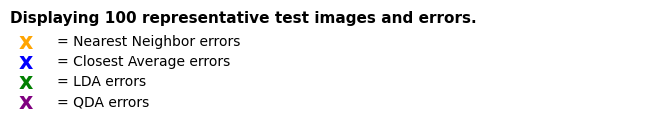

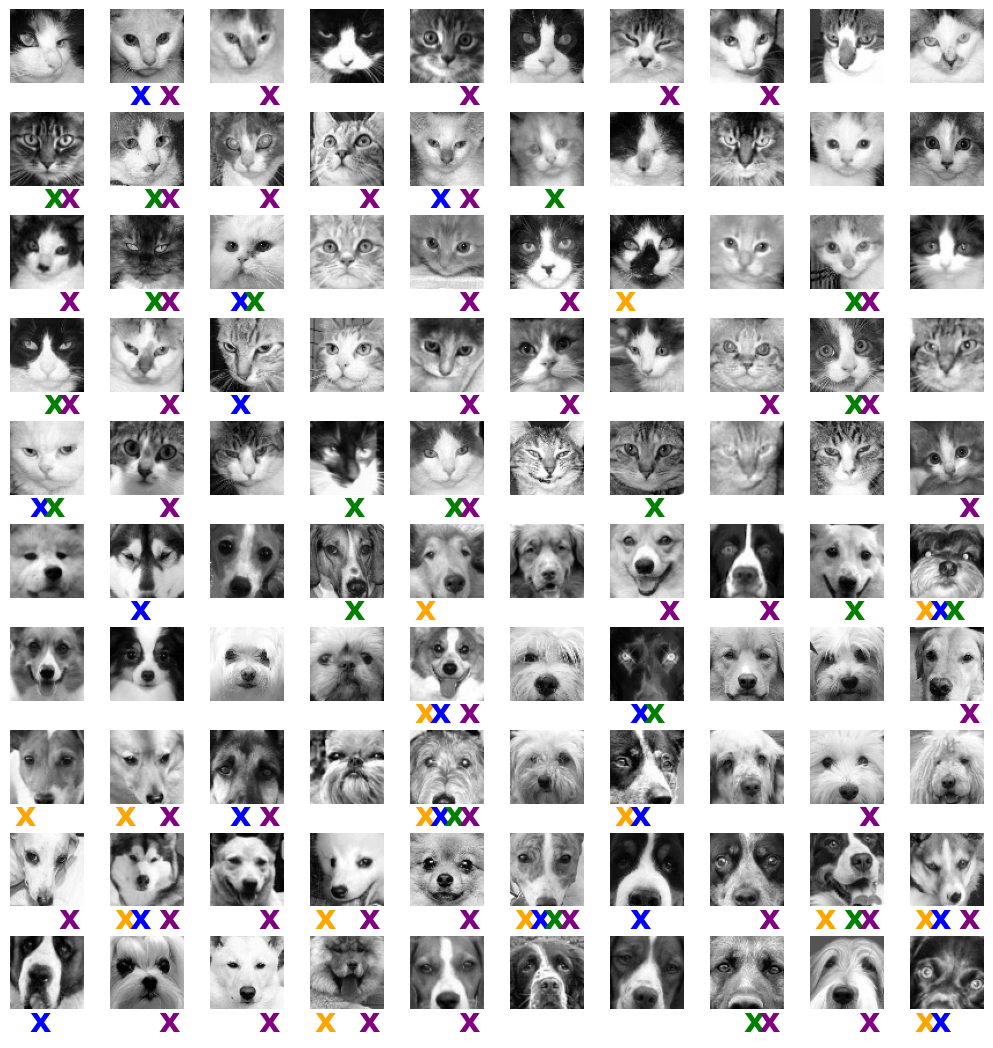

In [25]:
image_classifier(catdog_images,catdog_labels)

---
####  L11.3 Using the code above, run the classifiers on the cats and dogs dataset, and then answer the following questions.

#### (a) Which classifiers attain very low training error rates (i.e., close to zero)?

#### Answer: Nearest Neighbor & QDA

#### (b) Which classifiers attain reasonable (but not necessarily very low) test error rates? (Recall that 0.5 is the worst-possible performance, since you could attain this value by always guessing "cat".)

#### Answer: Nearest Neighbor

#### (c) Are any classifiers (other than nearest neighbor, which always has zero training errors), overfitting to the training data? This happens when the training error is low but the test error is significantly higher.

#### Answer: QDA

#### (d) Argue why these classifiers might be overfitting in terms of the number of unknown variables/parameters and the number of equations/examples. (Go back and read the text above for some discussion of this.)

#### Answer: It could have remembered the training data pattern since the sample is too small so when it was used with the testing data, it would return error to most of the picture that is not similar to the training data picture even if it is of the same animal.

#### (e) Based on the number of available examples, roughly how many parameters do you think we should be fitting to the dataset?

#### Answer: 1,000 parameters

#### (f) Is any classifier making "one-sided" errors, i.e., making significantly more errors on cats than dogs (or vice versa)?

#### Answer: Nearest Neighbor
---

Let's see if the performance of our classifiers changes when we apply them to a different dataset. The code below loads 5000 examples from the MNIST dataset of handwritten digits. Each example is a 28 x 28 grayscale image of a handwritten number from 0 to 9. If we can train a classifier to perform well on this dataset, then we can use it for automatic character recognition (e.g., this is how Gradescope automatically reads your UID).

One thing to note is that, instead of 2 classes of images (e.g., cats and dogs), we now have 10 classes. All of our classifiers work in the same way, except they will now decide between 10 different options (e.g., closest mean amongst 10 means, highest likelihood between 10 Gaussians). There is no need to modify the `image_classifier` code.

In [26]:
num_mnist_samples = 5000 #max 70000
# Load MNIST data from OpenML
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
# Extract first num_mnist_samples examples
mnist_images, mnist_labels = mnist.data[:num_mnist_samples], mnist.target[:num_mnist_samples]
# Convert labels to integers
mnist_labels = mnist_labels.astype(int)
mnist_img_shape = (28,28) #MNIST images are 28 x 28.

/opt/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


---
####  L11.4 Look at a few example images in the dataset using `show_image`. You will need to add the parameter `img_shape=mnist_img_shape` to display them properly. Then, run the cell below to generate and display images of the average handwritten digit from 0 to 9. (The labels are just 0 to 9.) Based on these average images, do you think the closest average classifier will be able to attain a test error rate below 0.5?

#### Answer: I think the closest average classifier will be able to attain a test error rate below 0.5 since there is a significant different between each number.
---

Average of all 0 Images


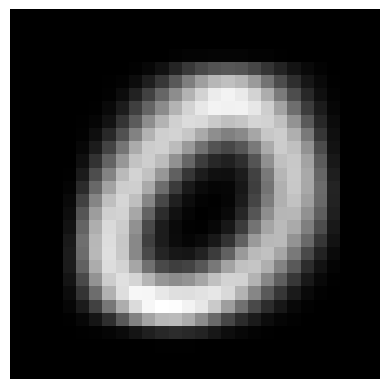

Average of all 1 Images


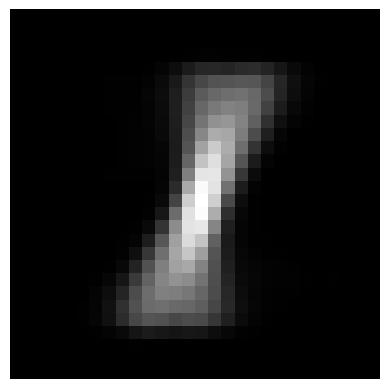

Average of all 2 Images


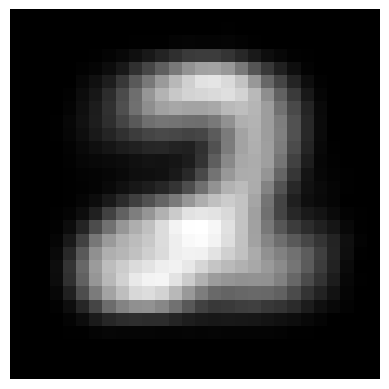

Average of all 3 Images


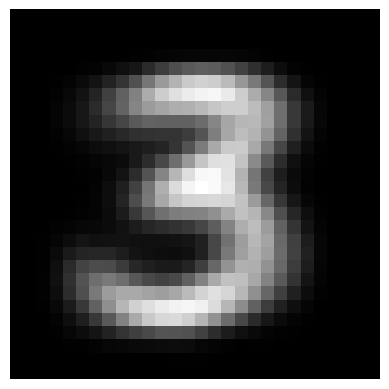

Average of all 4 Images


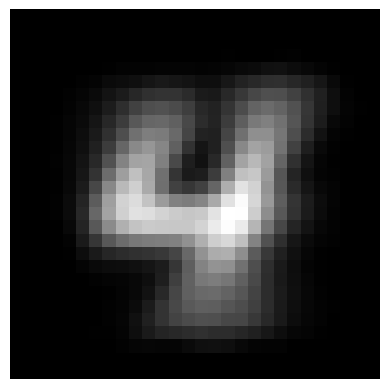

Average of all 5 Images


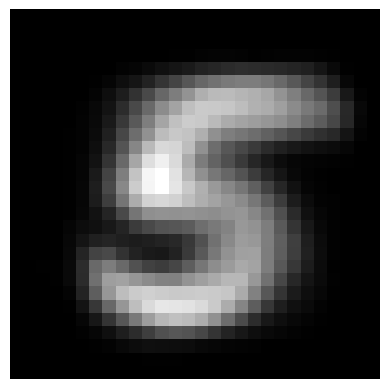

Average of all 6 Images


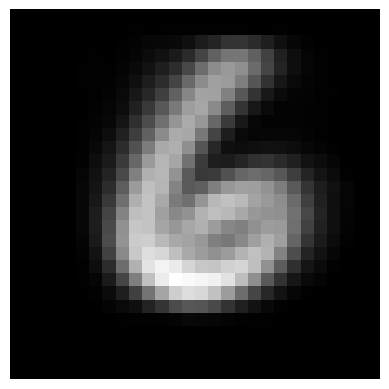

Average of all 7 Images


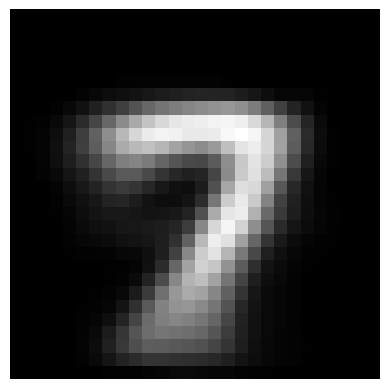

Average of all 8 Images


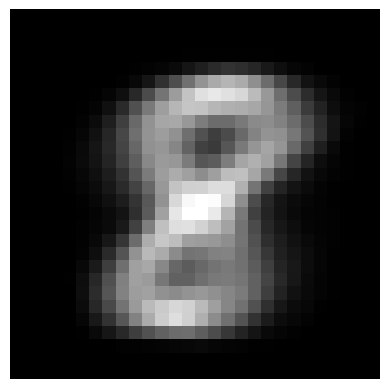

Average of all 9 Images


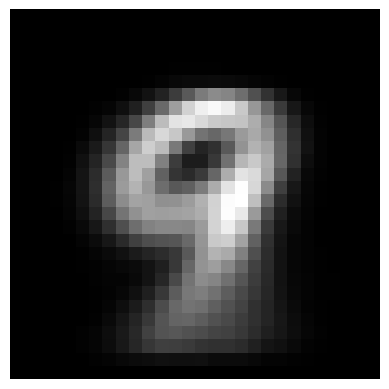

In [27]:
for i in np.arange(0,10):
    avgimg = np.mean(mnist_images[mnist_labels==i],axis=0)
    print(f'Average of all {i} Images')
    show_image(avgimg,img_shape=mnist_img_shape)

---
####  L11.5 Run the `image_classifier` code on the MNIST dataset, remembering to set `img_shape=mnist_img_shape` to display (28 x 28) images properly, and answer the following questions.

#### (a) Which classifiers attain very low training error rates (i.e., close to zero)? 

#### Answer: Nearest Neighbor, QDA and LDA

#### (b) Which classifiers attain reasonable (but not necessarily very low) test error rates? 

#### Answer: Nearest Neighbor, Closest Average and LDA

#### (c) Argue why the QDA error rate is above 0.5, using the fact that there are now than 10 classes instead of 2.

#### Answer: When there are more than two classes, QDA's error rate increases because the model becomes more complex.

#### (d) Is the overall behavior the same as you observed for the cats and dogs dataset? Comment on any aspects that have changed significantly.

#### Answer: It shares the similar overall behavior with the cats and dogs dataset.
---

Processing fold 1 of 5...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Processing fold 2 of 5...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Processing fold 3 of 5...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Processing fold 4 of 5...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Processing fold 5 of 5...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")



Training Error Rates:
Nearest Neighbor: Average Training Error Rate: 0.00
Closest Average: Average Training Error Rate: 0.19
LDA: Average Training Error Rate: 0.07
QDA: Average Training Error Rate: 0.00

Testing Error Rates:
Nearest Neighbor: Average Testing Error Rate: 0.06
Closest Average: Average Testing Error Rate: 0.19
LDA: Average Testing Error Rate: 0.17
QDA: Average Testing Error Rate: 0.67


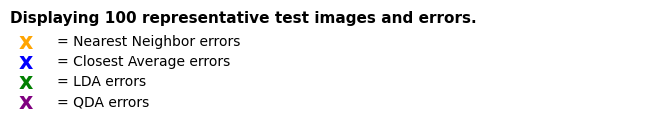

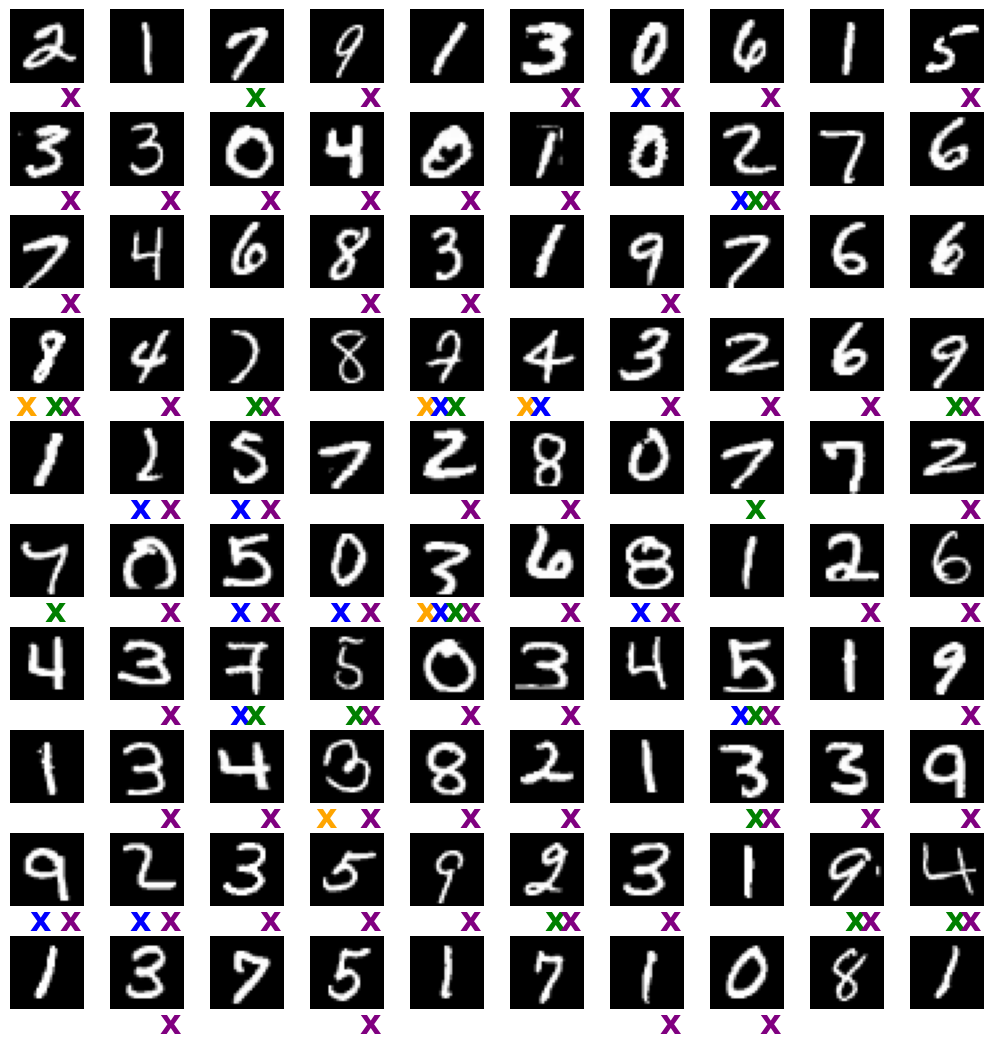

In [28]:
image_classifier(mnist_images,mnist_labels,img_shape=mnist_img_shape)

This function `gaussian_contour_lines` below is code from a previous lab that takes in a mean vector `mu` and covariance matrix `Sigma` and plots the resulting Gaussian contours.

In [29]:
def gaussian_contour_lines(mu,Sigma,cmap='Blues'):
    #Convert pandas objects to numpy arrays if needed
    if isinstance(mu, pd.Series):
        mu = mu.to_numpy()
    if isinstance(Sigma, pd.DataFrame):
        Sigma = Sigma.to_numpy()
    #Display error message if a requested variance is negative.
    plotscale = 2
    xmin = mu[0] - plotscale*np.sqrt(Sigma[0,0])
    xmax = mu[0] + plotscale*np.sqrt(Sigma[0,0])
    ymin = mu[1] - plotscale*np.sqrt(Sigma[1,1])
    ymax = mu[1] + plotscale*np.sqrt(Sigma[1,1])

    grid_size = 100
    
    # Create a grid of (x,y) points
    x = np.linspace(xmin,xmax,grid_size)
    y = np.linspace(ymin,ymax,grid_size)
    X, Y = np.meshgrid(x,y)

    # Evaluate Gaussian joint PDF over the grid
    pos = np.dstack((X, Y))
    f_XY = st.multivariate_normal(mu,Sigma).pdf(pos)

    plt.contour(X,Y,f_XY,cmap=cmap, linewidths=2, levels=5, alpha=0.7)

Below, we have generated 200 pairs of jointly Gaussian random variables X and Y, displayed the resulting Gaussian contours, and the principal eigenvector as a red arrow (i.e., the eigenvector corresponding to the largest eigenvalue). Notice that the arrow is always aligned with the semi-major axis of the ellipse corresponding to the Gaussian contour. Experiment with the means, variances, and correlation coefficient below to see that this is indeed the case.

More generally, **the eigenvectors of the covariance matrix are equivalent to the semi-axes of the ellipse formed by the Gaussian contours, even in a higher-dimensional setting.**



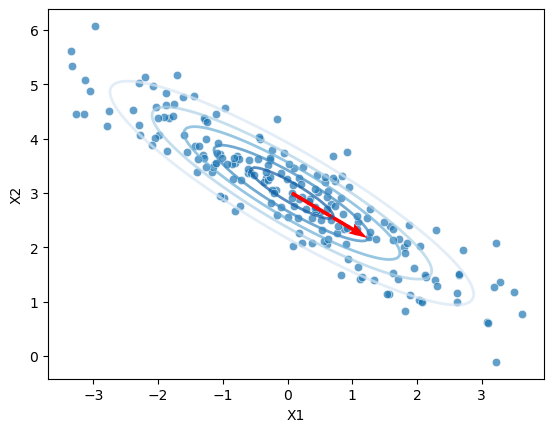

In [30]:
EX = 0
EY = 3
VarX = 2
VarY = 1
rhoXY = -0.9 #Easier to work with the correlation coefficient
mu = np.array([EX,EY]) #Organize into mean vector
CovXY = rhoXY * np.sqrt(VarX*VarY) #Calculate covariance
Sigma = np.array([[VarX, CovXY],[CovXY, VarY]]) #Organize into covariance matrix
GaussianRVs = st.multivariate_normal.rvs(mu,Sigma,200) #Generate Gaussian random variables
Gaussian_df = pd.DataFrame(columns=["X1","X2"],data=GaussianRVs) #Create a dataframe
sns.scatterplot(data=Gaussian_df,x = "X1", y = "X2",alpha=0.7) #Scatter plot
gaussian_contour_lines(Gaussian_df.mean(),Gaussian_df.cov(),cmap='Blues')
pca = PCA()
pca.fit(Gaussian_df)
eigenvectors = pca.components_  # Rows are the eigenvectors
mean = pca.mean_  # Mean of the data
plt.quiver(mean[0], mean[1], eigenvectors[0, 0], eigenvectors[0, 1], 
           angles='xy', scale_units='xy', scale = 0.7, color='red')

**Principal component analysis (PCA)** uses the special structure of the eigenvectors of the covariance matrix to perform **dimensionality reduction**. The steps for PCA dimensionality reduction from $d$ to $k < d$ dimensions are:
- Find the sample mean vector $\hat{\underline{\mu}}$ and sample covariance matrix $\mathbf{\hat{\Sigma}}$ for the entire dataset.
- Find the eigenvectors $\underline{v}_1, \ldots, \underline{v}_d$ for $\mathbf{\hat{\Sigma}}$ (assumed to be ordered so that the eigenvalues are decreasing $\lambda_1 \geq \cdots \geq \lambda_d$).
- Center the dataset by subtracting the sample mean vector $\hat{\underline{\mu}}$.
- Rotate the dataset into the new coordinate system with basis vectors $\underline{v}_1, \ldots, \underline{v}_d$. (To find the $i^{\text{th}}$ coordinate of $\underline{x}$ in the new basis, we take the inner product with the $i^{\text{th}}$ eigenvector, $\underline{v}_i^\top \underline{x}$.)
- Discard all but coordinates $1,\ldots,k$.

Intuitively, if there are directions along which the classes of data are well-separated, then a Gaussian contour fitted to the entire dataset will be stretched the most in these directions, and thus they can be discovered by the eigenvectors of the covariance matrix. The code below provides an illustration of this idea in two dimensions. The blue and the orange data points are well-separated along the direction $\begin{bmatrix} 1 \\ 1 \end{bmatrix}$ by design. A Gaussian contour fit to the entire data (ignoring the distinction between blue and orange) will discover this direction, represented by the principal eigenvector $\underline{v}_1$. Afterwards, we rotate into the new coordinate system where the eigenvectors correspond to the axes. Finally, we reduce the dimension by only retaining the first coordinate. 

Text(0.5, 1.0, 'PCA Dimensionality Reduction to 1 Dimension')

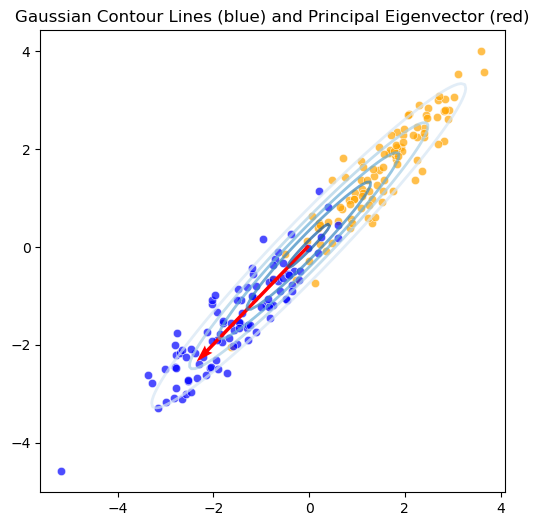

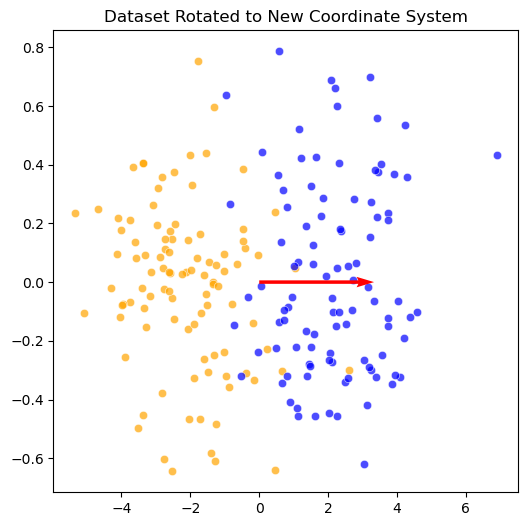

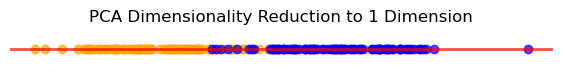

In [31]:
mu0 = np.array([+1.5,+1.5])
mu1 = np.array([-1.5,-1.5])
VarX = 1
VarY = 1
rhoXY = 0.9 #Easier to work with the correlation coefficient
CovXY = rhoXY * np.sqrt(VarX*VarY) #Calculate covariance
Sigma = np.array([[VarX, CovXY],[CovXY, VarY]]) #Organize into covariance matrix
label0data = st.multivariate_normal.rvs(mu0,Sigma,100) #Generate label 0 data
label1data = st.multivariate_normal.rvs(mu1,Sigma,100) #Generate label 1 data
fulldata = np.vstack((label0data,label1data))
fulldata_df = pd.DataFrame(columns=["X1","X2"],data=fulldata) 
plt.figure(figsize=(6,6))
sns.scatterplot(x=label0data[:,0],y=label0data[:,1],color='orange',alpha=0.7) #Scatter plot
sns.scatterplot(x=label1data[:,0],y=label1data[:,1],color='blue',alpha=0.7) #Scatter plot
gaussian_contour_lines(fulldata_df.mean(),fulldata_df.cov(),cmap='Blues')
pca = PCA()
pca.fit(fulldata)
eigenvectors = pca.components_  # Rows are the eigenvectors
mean = pca.mean_  # Mean of the data
plt.quiver(mean[0], mean[1], eigenvectors[0, 0], eigenvectors[0, 1], 
           angles='xy', scale_units='xy', scale = 0.3, color='red')
plt.title('Gaussian Contour Lines (blue) and Principal Eigenvector (red)') 


plt.figure(figsize=(6,6))
rotated0data = pca.transform(label0data)
rotated1data = pca.transform(label1data)
sns.scatterplot(x=rotated0data[:,0],y=rotated0data[:,1],color='orange',alpha=0.7) #Scatter plot
sns.scatterplot(x=rotated1data[:,0],y=rotated1data[:,1],color='blue',alpha=0.7) #Scatter plot
plt.quiver(0,0,1,0, 
           angles='xy', scale_units='xy', scale = 0.3, color='red')
plt.title('Dataset Rotated to New Coordinate System') 


plt.figure(figsize=(7,0.5))
projected0data = pca.transform(label0data)[:,0]
projected1data = pca.transform(label1data)[:,0]
plt.scatter(projected0data, np.zeros_like(projected0data), color='orange', alpha=0.7, label='Label 0')
plt.scatter(projected1data, np.zeros_like(projected1data), color='blue', alpha=0.7, label='Label 1')
plt.axhline(0, color='red', linestyle='-', linewidth=2, alpha = 0.7)
# Remove the box (spines) around the figure
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.yticks([])
plt.xticks([])
plt.title('PCA Dimensionality Reduction to 1 Dimension') 



---
####  L11.6 For the example above, PCA dimensionality reduction preserves the separability of the blue and orange data points. Will this always be the case? Experiment with the values of `mu0`, `mu1`, `VarX`, `VarY`, and `rhoXY` to find a configuration where the blue and orange data is separated in two dimensions, but overlaps significantly when projected to one dimension. Report your values below.

#### mu0 = [+1.5,+1.5], mu1 = [-1.5,-1.5], VarX = 1, VarY = 1, rhoXY = 0.9
---

The function `pca_scatter_2d` below takes in a dataset `X` and its labels `y`, uses PCA dimensionality reduction to drop the dataset to 2 dimensions, and displays a scatter plot with a different color for each label.

In [32]:
def pca_scatter_2d(X, y):
    # Encode labels if they're not numeric
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Perform PCA to reduce to 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Create scatter plot
    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(y_encoded)
    
    for label in unique_labels:
        label_mask = y_encoded == label
        plt.scatter(X_pca[label_mask, 0], X_pca[label_mask, 1], label=le.inverse_transform([label])[0], alpha=0.7)
    
    plt.title("PCA Scatter Plot by Class")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Classes")
    plt.grid(True)
    plt.show()

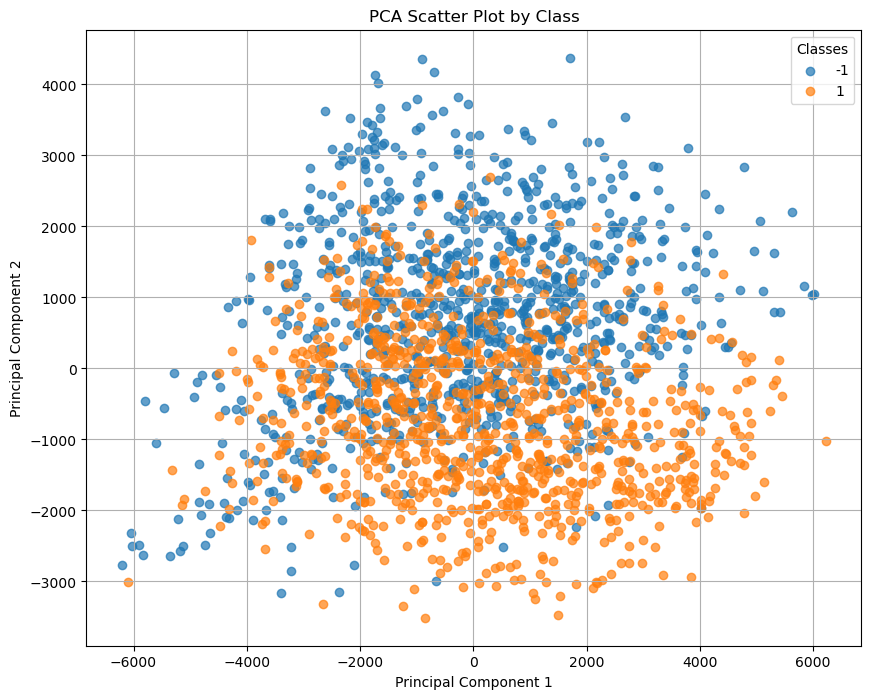

In [33]:
pca_scatter_2d(catdog_images,catdog_labels)

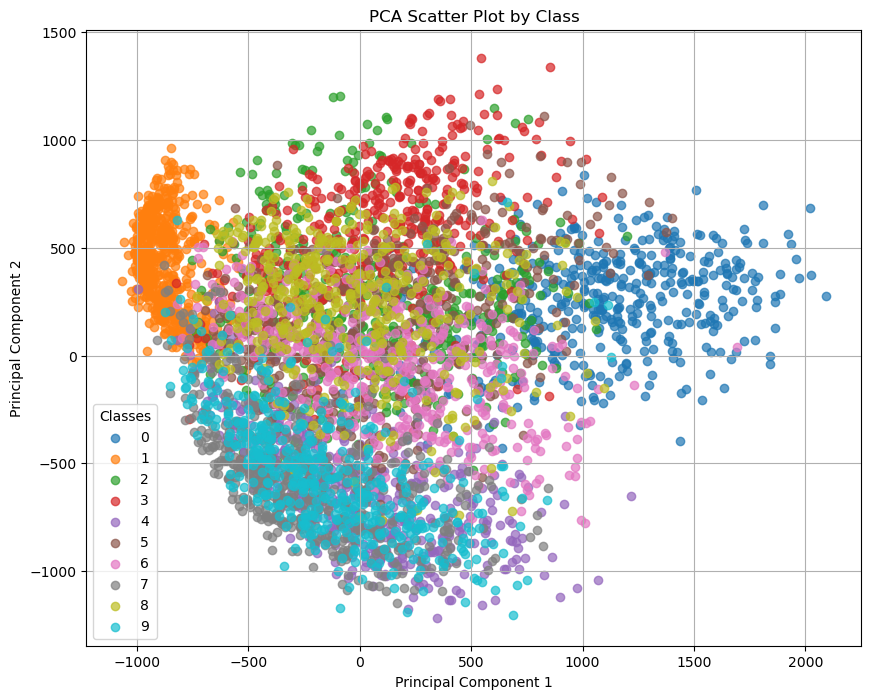

In [34]:
pca_scatter_2d(mnist_images,mnist_labels)

---
####  L11.7 The function `pca_scatter_2d` uses PCA dimensionality reduction to produce a 2-d scatter plot of any dataset. Above, we have run it on both the cats and dogs dataset as well as the MNIST digit dataset. Comment on what you observe. Do data points end up near other data points with the same label, or is very little structure preserved? From the plots, do you think it will be possible to get low error rates if we only keep the top-2 dimensions from PCA, or will more dimensions be needed?

#### Answer: For cats and dogs, the data points partially cluster while for MNIST the data points  with the same label show some grouping but for some digits, it is hard to see since some groups overlapped. For the cats and dogs dataset, low error rates are unlikely with only 2 dimensions, and more dimensions will be needed to separate the data effectively. For the MNIST dataset, even if the 2 dimensions provide a great separation of the data but to achieve a lower error rate, it will need more dimensions.
---

The `display_eigenimages` function below allows us to visualize the structure of the eigenvectors for image data. Consider the eigenvectors obtained from the covariance matrix from the cats and dogs dataset. Surprinsingly, if we display these 4096-dimensional eigenvectors as 64 x 64 images, we will see cat- and dog-like features. This is a well-known phenomenon for facial image datasets, known as eigenfaces. The problem below asks you to qualitatively describe the eigenvector images. 

In [35]:
def display_eigenimages(X, image_indices, img_shape=(64, 64)):
    # Perform PCA
    pca = PCA()
    pca.fit(X)
    eigenvectors = pca.components_  # Rows are the eigenvectors
    
    # Determine grid size
    n_images = len(image_indices)
    n_cols = int(np.ceil(np.sqrt(n_images)))
    n_rows = int(np.ceil(n_images / n_cols))
    
    # Create the figure
    plt.figure(figsize=(n_cols * 2.5, n_rows * 2.5))
    
    for i, idx in enumerate(image_indices):
        plt.subplot(n_rows, n_cols, i + 1)
        eigenimage = eigenvectors[idx].reshape(img_shape)
        eigenimage = eigenimage  # Reshape to the desired size
        plt.imshow(eigenimage, cmap='gray')
        plt.title(f"Eigenimage {idx}")
        plt.axis('off')
    
    plt.tight_layout(pad=3)
    plt.show()


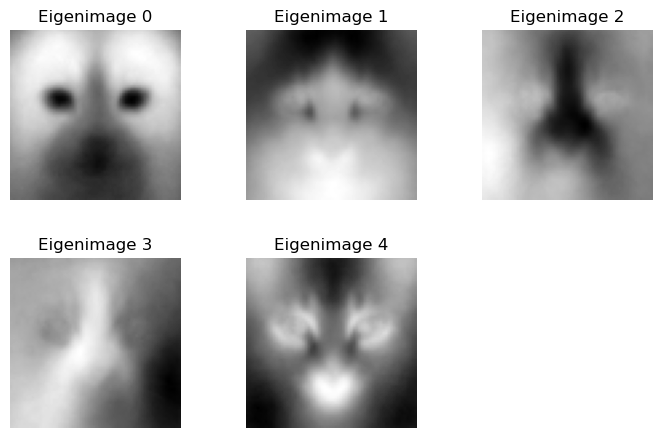

In [36]:
# List of eigenvector indices (0 to 1999) to display as images. 
image_indices = np.arange(0,5)
# Display the eigenimages
display_eigenimages(catdog_images, image_indices)

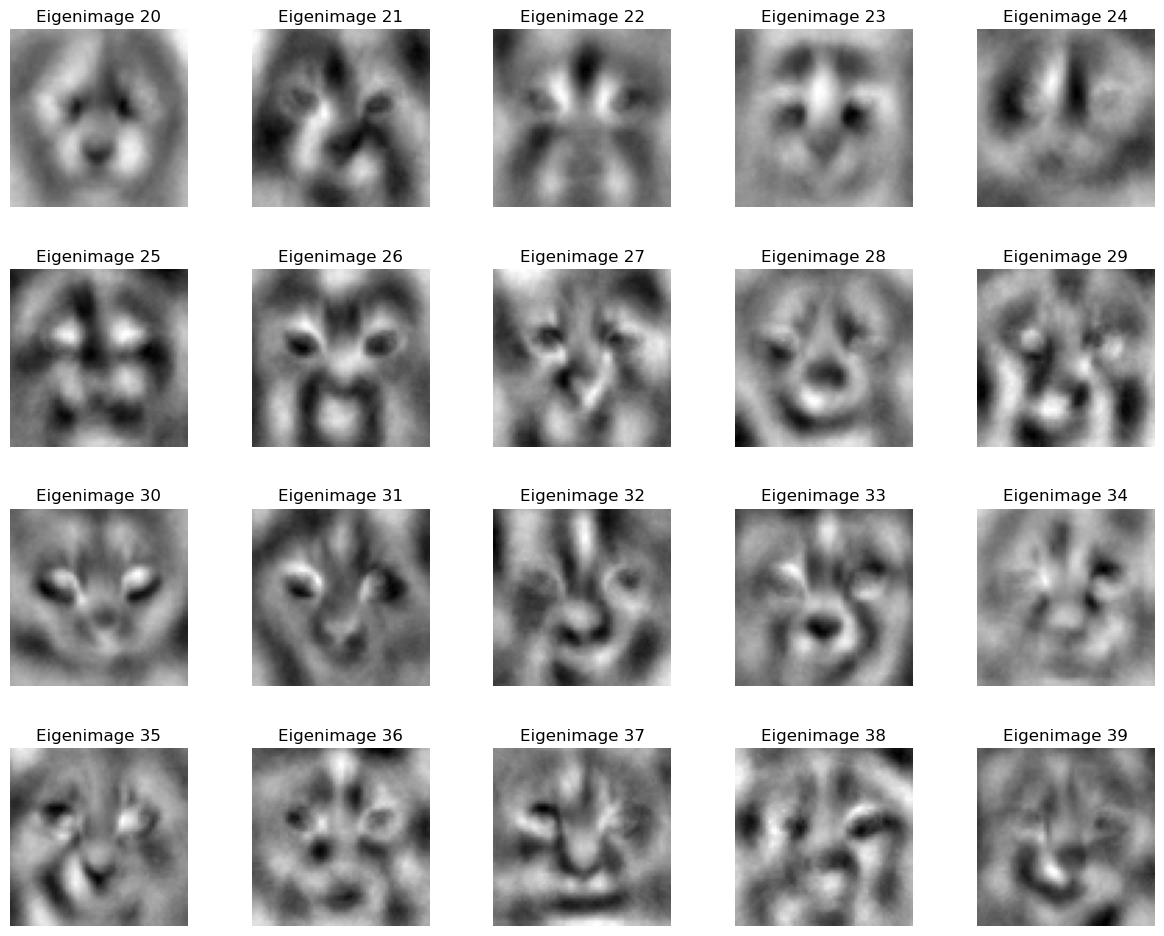

In [37]:
# List of eigenvector indices (0 to 1999) to display as images. 
image_indices = np.arange(20,40)
# Display the eigenimages
display_eigenimages(catdog_images, image_indices)

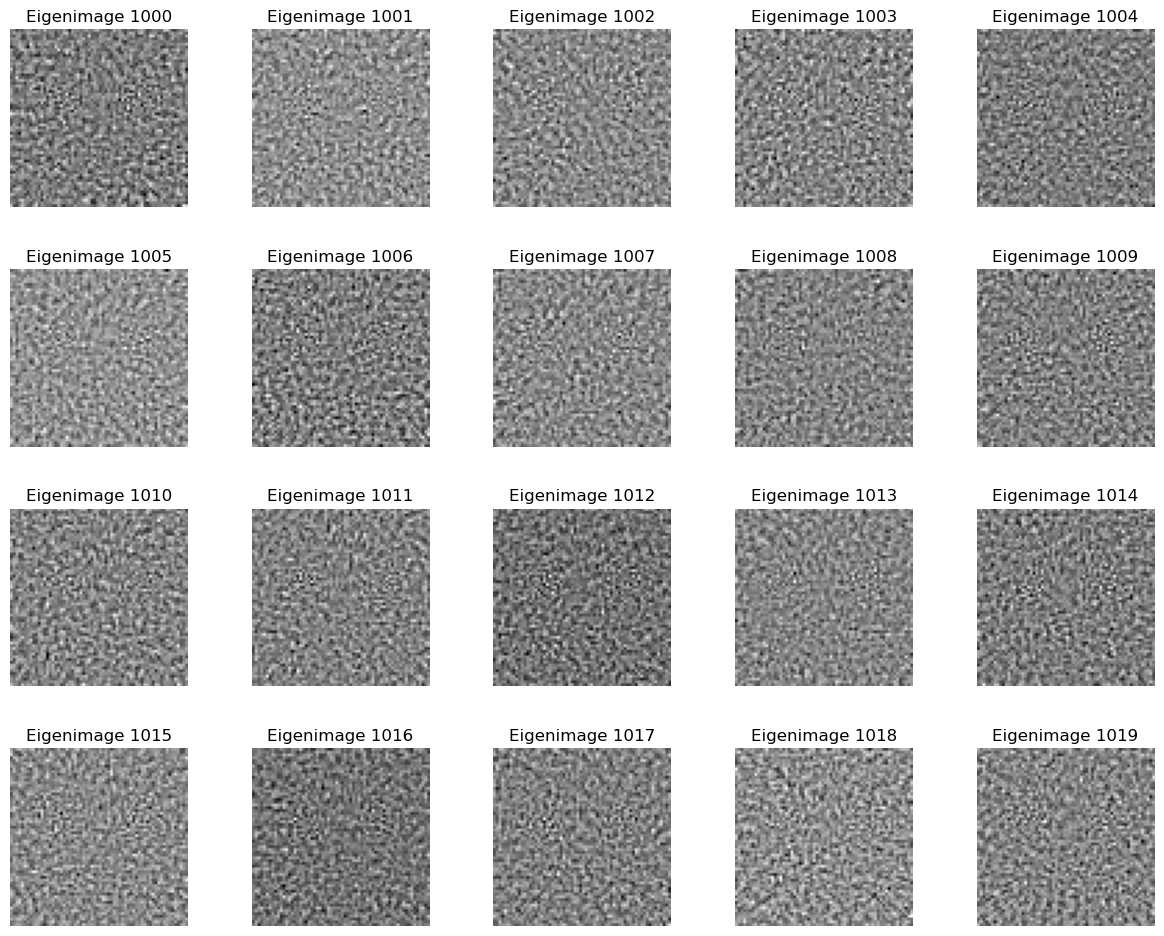

In [38]:
# List of eigenvector indices (0 to 1999) to display as images. 
image_indices = np.arange(1000,1020)
# Display the eigenimages
display_eigenimages(catdog_images, image_indices)

---
####  L11.8 The function `display_eigenimages` is run above on the cats and dogs dataset. Currently, it displays the first 5 eigenvectors as images, which you can see have a considerable degree of structure. In fact, these eigenvectors look like cats and dogs themselves. Your task in this problem is to explore the set of eigenvectors and describe the features of the images you see in your own words. This could range from facial features to "pure noise."

#### Provide a brief description for eigenvectors in the following ranges. (Ranges are rough and you just need to provide a single overall description, not one for each individual eigenvector.)

#### Eigenvectors 0 - 5: It shows the facial structural features like eyes, nose, andthe shape of the head. It's like a blurred picture of the cat and dog.

#### Eigenvectors 20 - 40: It also shows the facial features like eyes, nose, and a pettern of the fur.

#### Eigenvectors 100 - 200: It only shows the eyes, the noses and a lot of noise.

#### Eigenvectors 1000 onwards: It captures just the noise.
---

The function `display_pca_projections` below shows the approximations of a specific image, selected by `image_index`, for different levels of PCA dimensionality reduction. The numbers of dimensions to use for each approximation are taken from `dimensions_list` and the resulting images are shown as a grid.

In [39]:
def display_pca_projections(X, image_index, dimensions_list, img_shape=(64,64)):
    # Perform PCA
    pca = PCA()
    pca.fit(X)
    eigenvectors = pca.components_  # Eigenvectors
    mean_image = pca.mean_          # Mean image
    original_image = X[image_index]  # Original image row from X
    
    # Prepare the figure
    n_images = len(dimensions_list) + 1  # Include the original image
    n_cols = int(np.ceil(np.sqrt(n_images)))
    n_rows = int(np.ceil(n_images / n_cols))
    plt.figure(figsize=(n_cols * 3, n_rows * 3))
    
    # Display the original image
    plt.subplot(n_rows, n_cols, 1)
    plt.imshow(original_image.reshape(img_shape), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    
    # Display PCA approximations
    for i, n_components in enumerate(dimensions_list):
        pca_projection = PCA(n_components=n_components)
        reduced = pca_projection.fit_transform(X)
        reconstructed = pca_projection.inverse_transform(reduced[image_index].reshape(1, -1))
        
        plt.subplot(n_rows, n_cols, i + 2)
        plt.imshow(reconstructed.reshape(img_shape), cmap='gray')
        plt.title(f"{n_components} PCA Components")
        plt.axis('off')
    
    plt.tight_layout(pad=3)
    plt.show()


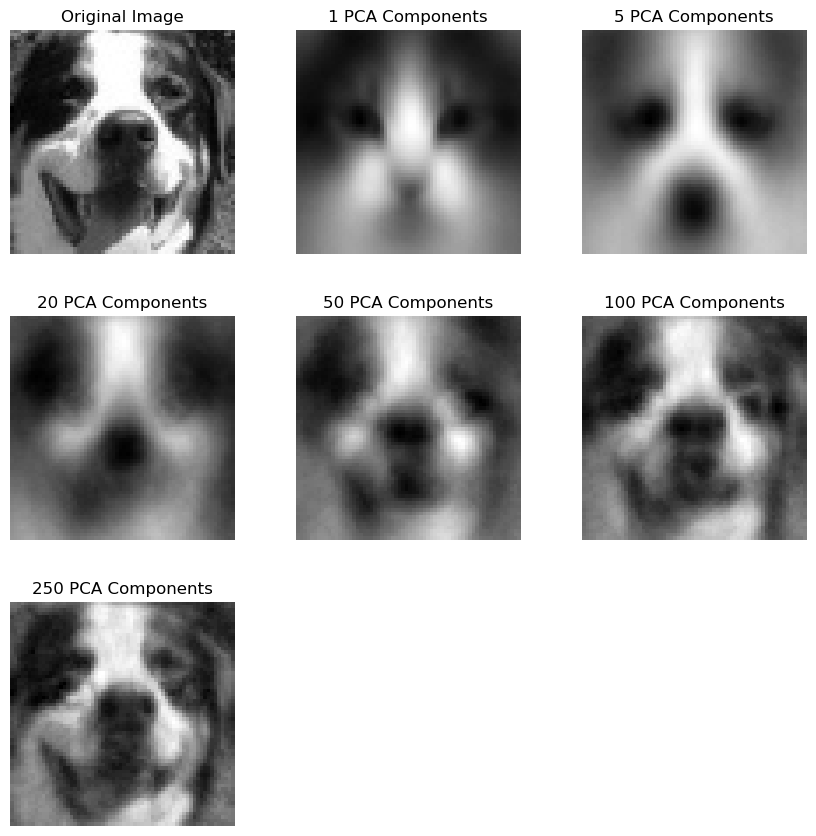

In [40]:
image_index = 1050 # Index of the image to 
dimensions_list = [1,5,20,50,100,250]  # Number of PCA components to project onto

# Display the original and approximated images
display_pca_projections(catdog_images, image_index, dimensions_list)

---
####  L11.9 Using the `display_pca_projections` function, examine the effect of PCA dimensionality reduction on the image quality, and answer the following questions:

#### (a) How many dimensions are needed before you can (barely) make out whether the image is actually a cat or a dog? (Recall that cats are indexed 0 to 999 and dogs 1000 to 1999.) 
#### Answer: 50 dimensions

#### (b) How many dimensions are needed before you get a reasonable approximation of the image? 
#### Answer: 100 dimensions

#### (c) How many dimensions are needed before it is hard to notice differences between the original and the approximation? 
#### Answer: 250 dimensions

#### (d) Based on your explorations above, make an educated guess as to how many dimensions to retain for PCA dimensionality reduction, if our goal is to train a binary classification algorithm to the dimensionality-reduced data? 
#### Answer: 100 dimensions.

#### (e) Using the cell below, run PCA dimensionality reduction for your selected dimension, followed by binary classification. Has the testing error rate improved for any of the classifiers, compared to your values obtained as part of 11.3 above?  
#### Answer: The testing error rate improved for Nearest Neighbor, LDA and QDA
---

In [41]:
num_dimensions_retained = 150 #Change this value to your guess from (d)
catdog_pca = PCA()
catdog_pca.fit(catdog_images)
catdog_images_pca = catdog_pca.transform(catdog_images)[:,0:num_dimensions_retained]
image_classifier(catdog_images_pca,catdog_labels,display_images=False)

Processing fold 1 of 5...
Processing fold 2 of 5...
Processing fold 3 of 5...
Processing fold 4 of 5...
Processing fold 5 of 5...

Training Error Rates:
Nearest Neighbor: Average Training Error Rate: 0.00
Closest Average: Average Training Error Rate: 0.20
LDA: Average Training Error Rate: 0.05
QDA: Average Training Error Rate: 0.01

Testing Error Rates:
Nearest Neighbor: Average Testing Error Rate: 0.15
Closest Average: Average Testing Error Rate: 0.20
LDA: Average Testing Error Rate: 0.08
QDA: Average Testing Error Rate: 0.06


Is there a more principled way to select the number of dimensions to retain? This is a common issue encountered in machine learning: we have one (or more) parameters that need to be selected to run the classifier. One idea is to set the parameters using the data itself. Of course, we are not allowed to use the testing data. Instead, we need to split the data even further, introducing the idea of a **validation dataset**. 

Let's start by setting aside some of our data as testing data, which we will not use until the very end. The remaining data will be split into several folds. To start, we designated the first fold as a **validation** dataset, and use the remaining folds as training. For each possible choice of the dimension, we train each classifier on the training folds and evaluate its performance using the validation fold, saving the resulting error rates. 

Next, we designate the second fold as the validation data, and the remaining folds as training. We retrain the classifiers for each dimension, and ontain new training and validation error rates for every choice of the dimension, saving them as well. We repeat this process until every fold has acted as a validation fold once, and then average all of our saved training and validate error rates for each dimension.

Plotting the average training and validation error rates with respect to the dimension values should reveal that:
- The training error rate decreases as the dimension increases, since the classifier becomes more complex is better able to memorize the training data.
- The validation error rate will decrease as the dimension increases, but, after a certain point, it  will start increasing again. This increase is caused by the classifier **overfitting** to the training data.

For each classifier, we should select the dimension as the value that minimizes the average validation error rate. This choice of dimension will likely vary across classifiers, datasets, and even different runs (due to randomization in the training/testing split). 

Once we have selected the dimension for each classifier, we can finally return to the testing dataset to compare the classifiers (each operating with their best dimension). We can use the test error rates to determine which type of classifier is the best choice for the dataset.

The function `classifiers_with_pca` below takes in a dataset X and its labels y, along with a list of dimensions `dimensions_list` to try for PCA dimensionality reduction. It saves a fraction `test_size` of the data as a testing dataset and then splits the remaining training data into `num_folds` folds. For every dimension in `dimensions_list`, it evaluates the training and validation error, averaged across folds, and plots the results for each classifier. It selects the best dimension for each classifier, and evaluates the testing error rate. The lowest amongst these testing error rates corresponds to the best classifier for the particular dataset.

In [42]:
def classifiers_with_pca(X, y, dimensions_list, test_size=0.2, num_folds=5):

    # Classifiers to evaluate
    classifiers = {
        "Nearest Neighbor": KNeighborsClassifier(n_neighbors=1),
        "Closest Average": NearestCentroid(),
        "LDA": LinearDiscriminantAnalysis(),
        "QDA": QuadraticDiscriminantAnalysis()
    }
    
    colors = ["orange", "blue", "green", "purple"]
    
    # Split into training/validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y
    )
    
    # Initialize Stratified K-Fold cross-validator
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True)
    
    best_dims = {}
    test_errors = {}
    
    # Store errors for plotting
    error_tracking = {name: {"train_errors": [], "val_errors": []} for name in classifiers}
    
    # PCA dimensionality search
    for name, clf in classifiers.items():
        print(f"\nProcessing {name}...")
        train_errors_per_dim = []
        val_errors_per_dim = []

        for dim in dimensions_list:
            print(f"  Trying PCA dimension {dim}...")
            train_fold_errors = []
            val_fold_errors = []

            for train_idx, val_idx in skf.split(X_train_val, y_train_val):
                X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
                y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

                # Apply PCA
                pca = PCA(n_components=dim)
                X_train_pca = pca.fit_transform(X_train)
                X_val_pca = pca.transform(X_val)
                
                # Fit classifier
                clf.fit(X_train_pca, y_train)
                
                # Calculate errors
                train_error = 1 - clf.score(X_train_pca, y_train)
                val_error = 1 - clf.score(X_val_pca, y_val)
                
                train_fold_errors.append(train_error)
                val_fold_errors.append(val_error)
            
            # Average over folds
            train_errors_per_dim.append(np.mean(train_fold_errors))
            val_errors_per_dim.append(np.mean(val_fold_errors))
        
        # Save errors for this classifier
        error_tracking[name]["train_errors"] = train_errors_per_dim
        error_tracking[name]["val_errors"] = val_errors_per_dim
        
        # Select best dimension
        best_dim_idx = np.argmin(val_errors_per_dim)
        best_dim = dimensions_list[best_dim_idx]
        best_dims[name] = best_dim
        print(f"  Best PCA dimension for {name}: {best_dim}")
        
        # Evaluate on held-out test set
        pca = PCA(n_components=best_dim)
        X_train_val_pca = pca.fit_transform(X_train_val)
        X_test_pca = pca.transform(X_test)
        
        clf.fit(X_train_val_pca, y_train_val)
        test_error = 1 - clf.score(X_test_pca, y_test)
        test_errors[name] = test_error
        print(f"  Test error for {name} (best PCA dimension): {test_error:.2f}")
    
    # Plot training and validation errors
    plt.figure(figsize=(10, 6))
    for idx, (name, clf) in enumerate(classifiers.items()):
        train_errors = error_tracking[name]["train_errors"]
        val_errors = error_tracking[name]["val_errors"]
        
        plt.plot(dimensions_list, train_errors, label=f"{name} - Training Error", marker='o', color=colors[idx])
        plt.plot(dimensions_list, val_errors, label=f"{name} - Validation Error", marker='x', color=colors[idx])
    
    plt.xlabel("PCA Dimension")
    plt.ylabel("Error Rate")
    plt.title("Training and Validation Errors for Different PCA Dimensions")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()


Processing Nearest Neighbor...
  Trying PCA dimension 10...
  Trying PCA dimension 25...
  Trying PCA dimension 50...
  Trying PCA dimension 75...
  Trying PCA dimension 100...
  Trying PCA dimension 125...
  Trying PCA dimension 150...
  Trying PCA dimension 175...
  Trying PCA dimension 200...
  Trying PCA dimension 300...
  Trying PCA dimension 400...
  Best PCA dimension for Nearest Neighbor: 25
  Test error for Nearest Neighbor (best PCA dimension): 0.15

Processing Closest Average...
  Trying PCA dimension 10...
  Trying PCA dimension 25...
  Trying PCA dimension 50...
  Trying PCA dimension 75...
  Trying PCA dimension 100...
  Trying PCA dimension 125...
  Trying PCA dimension 150...
  Trying PCA dimension 175...
  Trying PCA dimension 200...
  Trying PCA dimension 300...
  Trying PCA dimension 400...
  Best PCA dimension for Closest Average: 175
  Test error for Closest Average (best PCA dimension): 0.17

Processing LDA...
  Trying PCA dimension 10...
  Trying PCA dimension 2

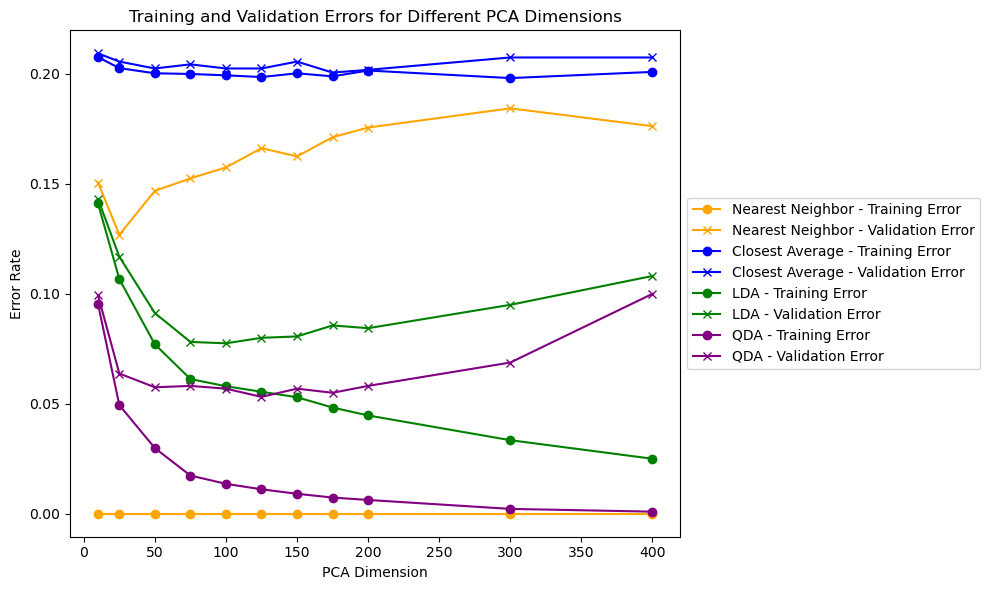

In [43]:
dimensions_list = [10,25,50,75,100,125,150,175,200,300,400]
classifiers_with_pca(catdog_images,catdog_labels,dimensions_list)

---
####  L11.10 Using the `classifiers_with_pca` function above (keeping the original dimensions_list), answer the following questions

#### (a) For the cats and dogs dataset, report the best dimension and corresponding test error rate for each classifier. Which classifier is the best overall?

#### Nearest Neighbor: Best Dimension =   25 , Test Error Rate = 0.12
#### Closest Average: Best Dimension = 150   , Test Error Rate = 0.22
#### LDA: Best Dimension =  125  , Test Error Rate = 0.10
#### QDA: Best Dimension =  150  , Test Error Rate = 0.06
#### Best Classifier Overall: QDA

#### (b) From the plot, at what dimension is the QDA classifier clearly overfitting? (This is when the validation error rate is obviously increasing while the training error rate is decreasing or neglible.)

#### Answer: More than 200 dimensions

#### (c) Has this overall process (dimensionality reduction + parameter selection via validation) significantly improved the performance compared to what you found in 11.3? How about compared to your guess for the best dimension from 11.9?

#### Answer: It improved a lot from 11.3 but it is worse than in 11.9

#### (c) One of the main lessons in machine learning is that there is no perfect classifier, and the performance can vary significantly across datasets. In a new cell, run `classifiers_with_pca` on the MNIST digit dataset for the same list of dimensions. Comment on some key differences you notice compared to the cats and dogs dataset. For instance, does each classifier still pick the same best dimension? Is the overall ranking of classifiers in terms of test error rate the same?

#### Answer: Nearest Neighbor, Closest Average and QDA has changed the best dimension.
The ranking is not the same, the LDA and the Nearest Neighbor switch places.
---


Processing Nearest Neighbor...
  Trying PCA dimension 10...
  Trying PCA dimension 25...
  Trying PCA dimension 50...
  Trying PCA dimension 75...
  Trying PCA dimension 100...
  Trying PCA dimension 125...
  Trying PCA dimension 150...
  Trying PCA dimension 175...
  Trying PCA dimension 200...
  Trying PCA dimension 300...
  Trying PCA dimension 400...
  Best PCA dimension for Nearest Neighbor: 50
  Test error for Nearest Neighbor (best PCA dimension): 0.05

Processing Closest Average...
  Trying PCA dimension 10...
  Trying PCA dimension 25...
  Trying PCA dimension 50...
  Trying PCA dimension 75...
  Trying PCA dimension 100...
  Trying PCA dimension 125...
  Trying PCA dimension 150...
  Trying PCA dimension 175...
  Trying PCA dimension 200...
  Trying PCA dimension 300...
  Trying PCA dimension 400...
  Best PCA dimension for Closest Average: 125
  Test error for Closest Average (best PCA dimension): 0.19

Processing LDA...
  Trying PCA dimension 10...
  Trying PCA dimension 2

/opt/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


  Trying PCA dimension 400...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/anaconda3/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


  Best PCA dimension for QDA: 25
  Test error for QDA (best PCA dimension): 0.04


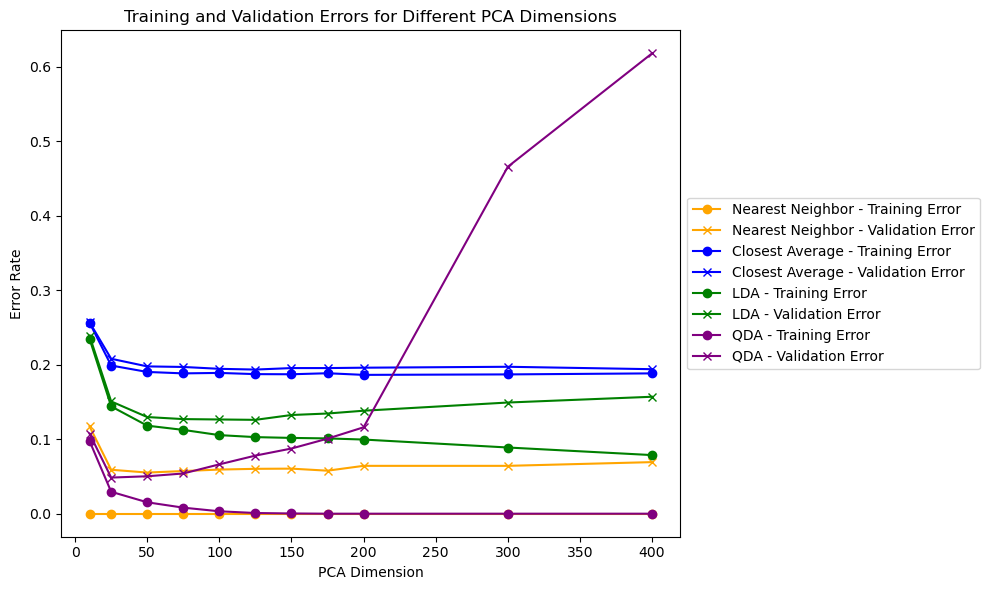

In [44]:
dimensions = [10,25,50,75,100,125,150,175,200,300,400]
classifiers_with_pca(mnist_images,mnist_labels,dimensions_list = dimensions)

---
#### L11.11 Finally, please clear all outputs so that your notebook file is not too large for Gradescope.
--- 